In [1]:
from salad.serialize import read
from pathlib import Path
from functools import lru_cache
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


In [2]:
@lru_cache()
def num_results(search_prefix, detector, snr, time_type, search_label):
    import re
    
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    clusters = list(p.rglob("clusters.pkl"))[0]
    gathered = list(
        sorted(
            filter(
                lambda x : re.compile("gathered_\d+.pkl").match(x.name) is not None,
                p.rglob("gathered*.pkl")
            ),
            key=lambda x : x.name
        )
    )
    dedup = list(p.rglob("deduplicated.pkl"))[0]
    filtered = list(p.rglob("filtered.pkl"))[0]
    
    
    n = []
    for f in [clusters] + gathered + [dedup] + [filtered]:
        n.append((f.name.replace(".pkl", ""), len(read(f))))
    return n

In [20]:
r = {}
for snr in [3.0, 4.0, 5.0]:
    r[snr] = []
    for d in range(1, 63):
        try:
            r[snr].append(num_results("new", d, snr, "regular", "asteroid")[-1][1])
        except:
            pass
        

In [26]:
sum(r[3.0]) / sum(r[5.0])

1.6579973992197659

In [3]:
def plot_num_results_snr(search_prefix, detector, search_label):
    fig = plt.figure(dpi=150)
    ls = {"regular": "-", "shuffled": ":"}
    color = {5.0: "C0", 4.0: "C1", 3.0: "C2"}

    
    for snr in [5.0, 4.0, 3.0]:
        for time_type in ["regular", "shuffled"]:
            n = num_results(search_prefix, detector, snr, time_type, search_label)
            x = [i for i in range(len(n))]
            y = [_[1] for _ in n]
            plt.plot(
                x, y, ls=ls.get(time_type), color=color.get(snr)
            )

    custom_lines = [
        Line2D([0], [0], color="k", lw=1, ls="-", label="Unshuffled"),
        Line2D([0], [0], color="k", lw=1, ls=":", label="Shuffled"),
        Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C0', label="SNR>=5"),
        Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C1', label="SNR>=4"),
        Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C2', label="SNR>=3"),
    ]
    plt.legend(handles=custom_lines)

    plt.xticks([i for i in range(8)], ["cluster\ndx=10", "refine\ndx=5", "refine\ndx=2.5", "refine\ndx=1.25", "refine\ndx=1", "refine\ndx=1", "dedup", "filter"])
    plt.ylabel("number of results")
    plt.xlabel("step")
    plt.title(f"detector={detector} search={search_label}/{search_prefix}")
    return fig

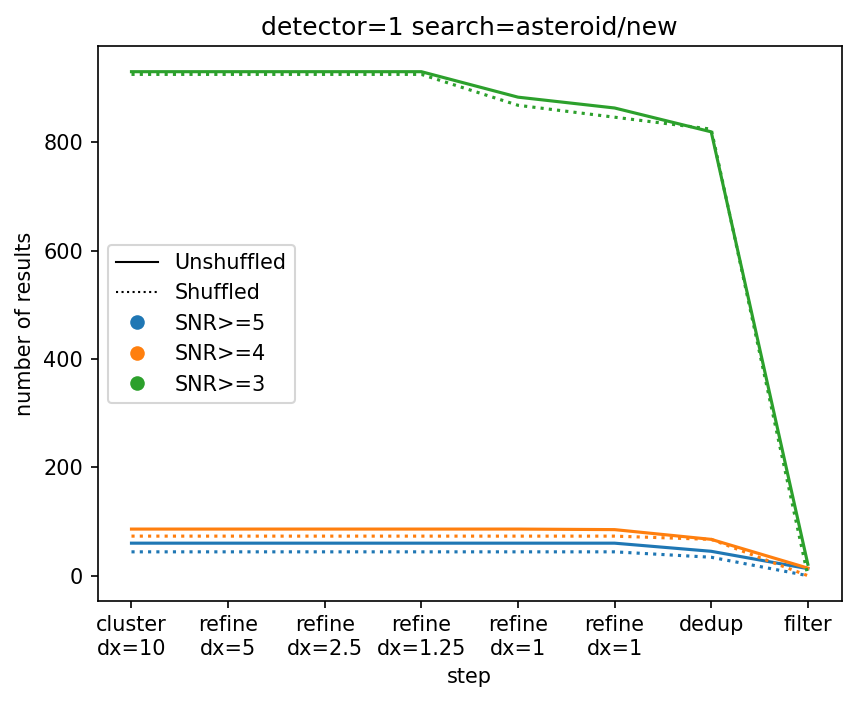

In [6]:
fig = plot_num_results_snr("new", 1, "asteroid")
plt.show()

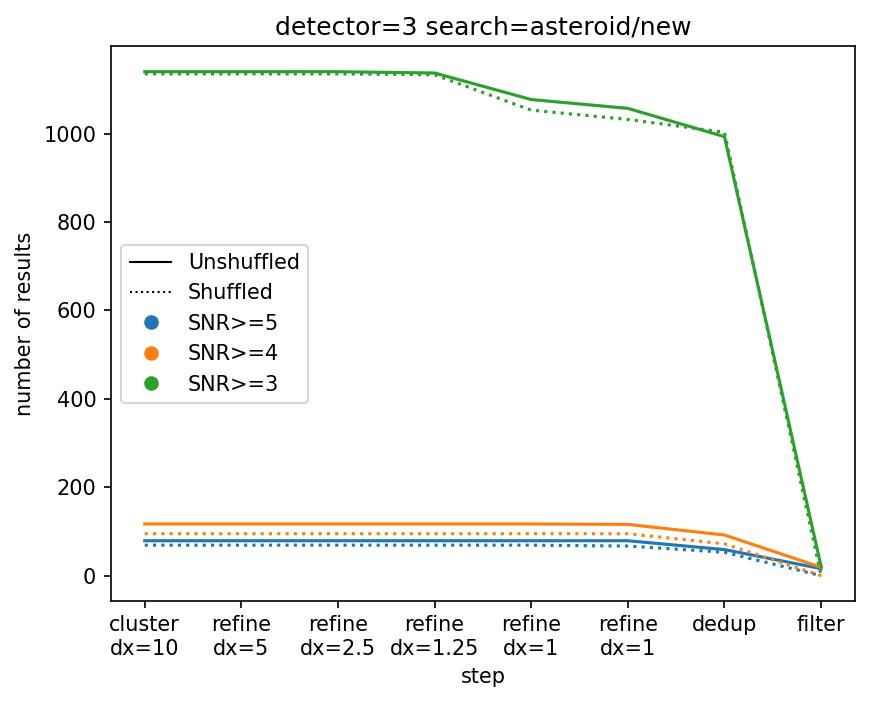

In [7]:
fig = plot_num_results_snr("new", 3, "asteroid")
plt.show()

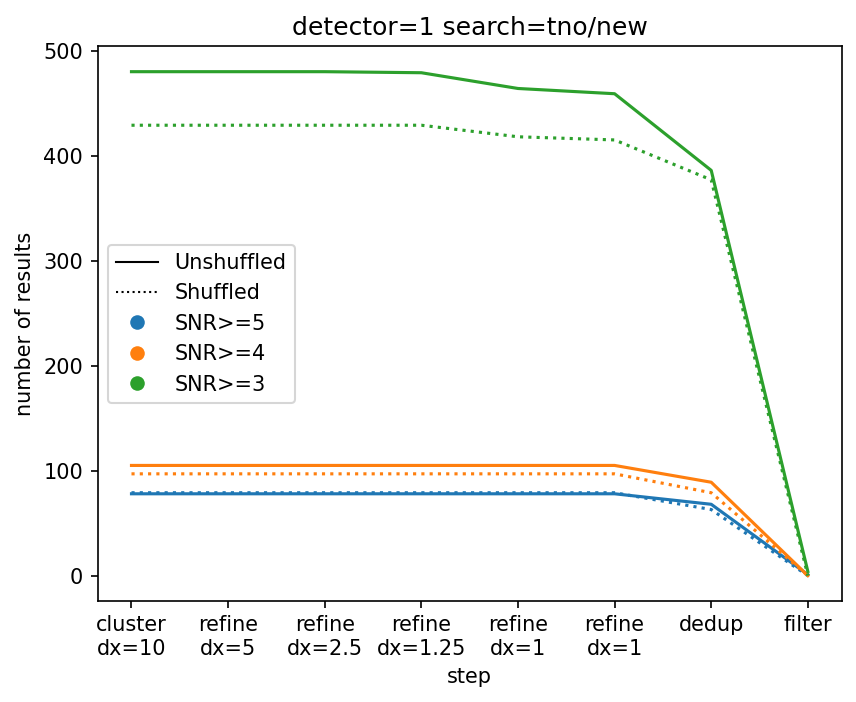

In [29]:
fig = plot_num_results_snr("new", 1, "tno")
plt.show()

In [8]:
@lru_cache
def last_step_num_results(vmin, vmax, n_min, n_max, search_prefix, detector, snr, time_type, search_label, snrs=[5.0, 4.0, 3.0], time_types=["regular", "shuffled"]):
    from salad.cluster.filter import filter_velocity, filter_n
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    dedup = read(list(p.rglob("deduplicated.pkl"))[0])
    filtered_v = {}
    for k in dedup:
        if filter_velocity(dedup[k], vmin=vmin, vmax=vmax):
            filtered_v[k] = dedup[k]
        
    y = []
    x = np.arange(n_min, n_max+1)
    for n in x:
        _y = 0
        for k in filtered_v:
            if filter_n(filtered_v[k], n=n):
                _y += 1
        y.append(_y)
    return x, y
    

In [9]:
def plot_last_step_num_results(vmin, vmax, n_min, n_max, search_prefix, detector, search_label, snrs=[5.0, 4.0, 3.0], time_types=["regular", "shuffled"]):
    fig = plt.figure(dpi=150)
    ls = {"regular": "-", "shuffled": ":"}
    color = {5.0: "C0", 4.0: "C1", 3.0: "C2"}
    
    
    for snr in snrs:
        for time_type in time_types:
            x, y = last_step_num_results(vmin, vmax, n_min, n_max, search_prefix, detector, snr, time_type, search_label)
            plt.plot(
                x, y, ls=ls.get(time_type), color=color.get(snr)
            )

    custom_lines = []
    for time_type in time_types:
        custom_lines.append(
            Line2D([0], [0], color="k", lw=1, ls=ls.get(time_type), label=time_type),
        )
    for snr in snrs:
        custom_lines.append(
            Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor=color.get(snr), label=f"SNR>={snr}"),
        )
#     custom_lines = [
        
#         Line2D([0], [0], color="k", lw=1, ls=":", label="Shuffled"),
#         Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C0', label="SNR>=5"),
#         Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C1', label="SNR>=4"),
#         Line2D([0], [0], marker="o", lw=0, color='w', markersize=8, markerfacecolor='C2', label="SNR>=3"),
#     ]
    
    plt.legend(handles=custom_lines)

    plt.xticks(x, list(map(str, x)))
    plt.ylabel("number of results")
    plt.xlabel("number of detections")
    plt.title(f"detector={detector} search={search_label}/{search_prefix}")
    return fig    
    

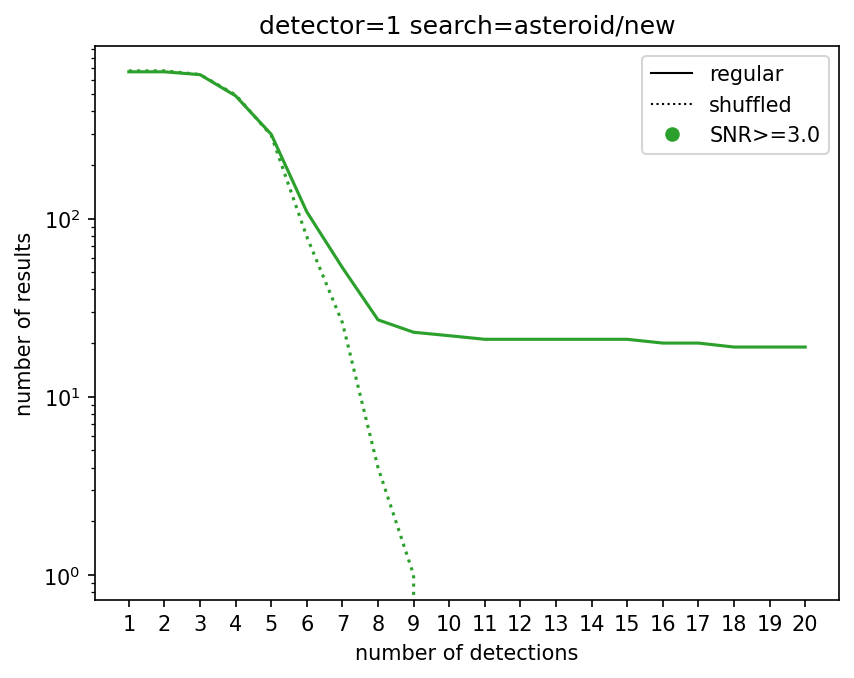

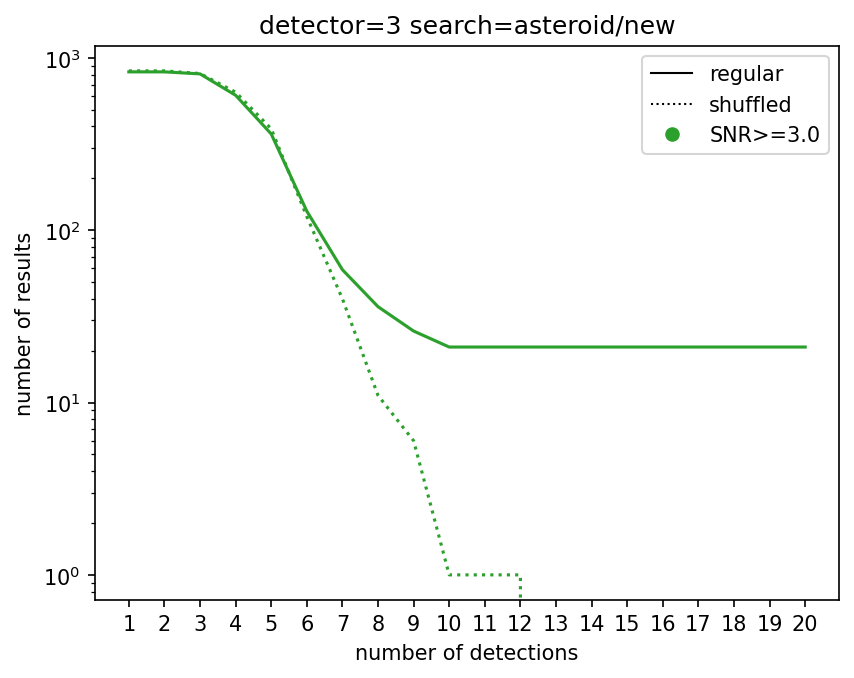

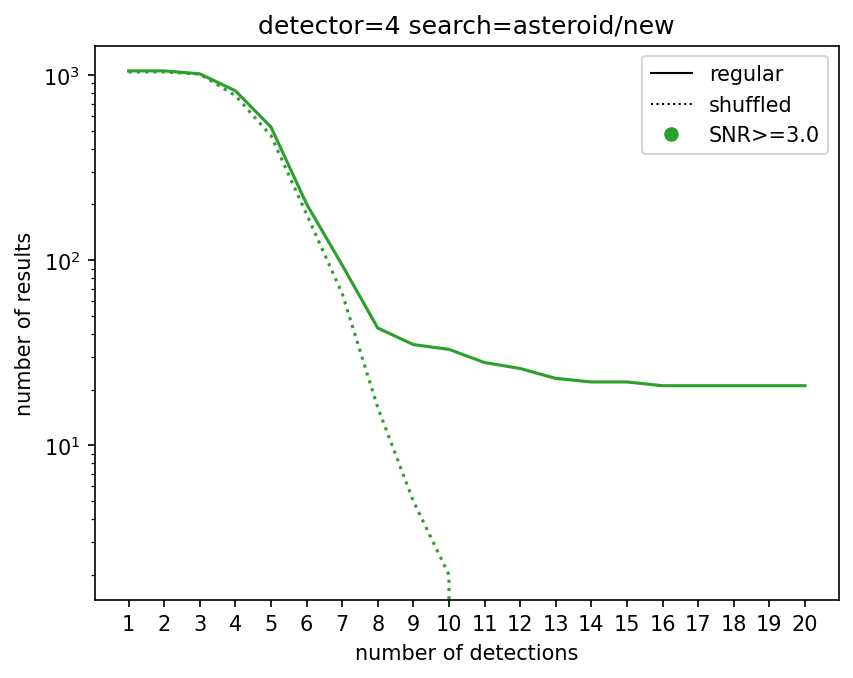

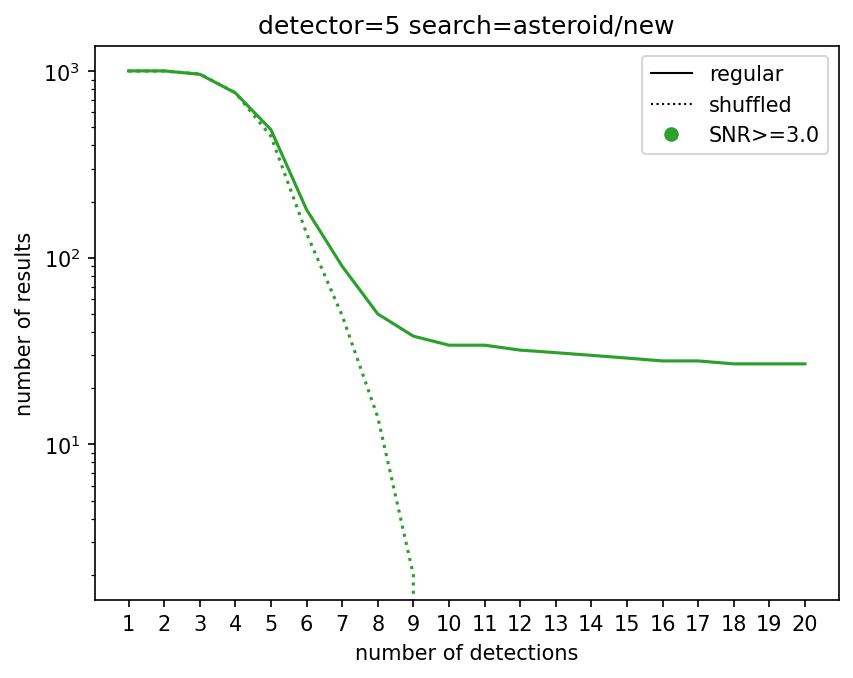

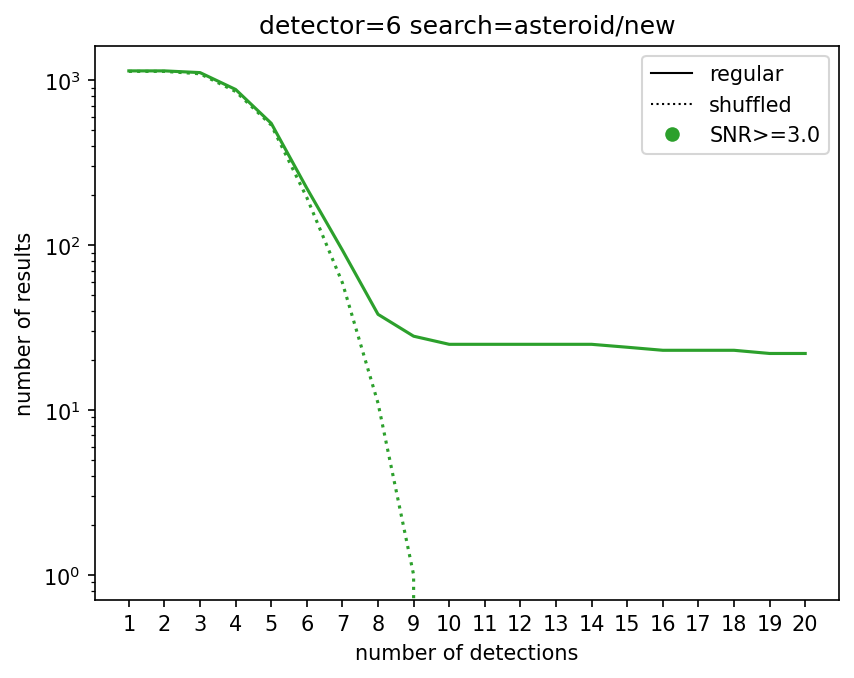

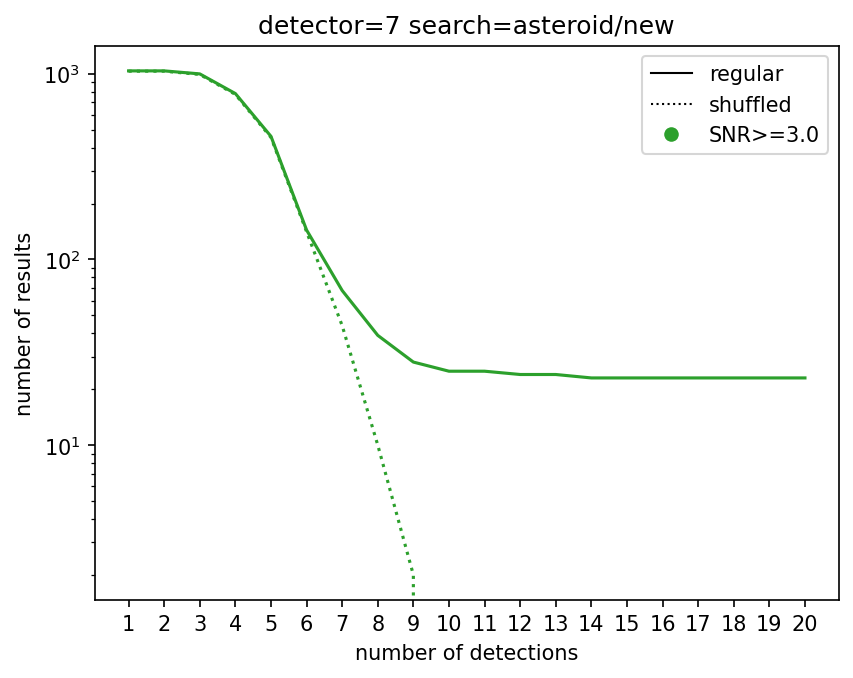

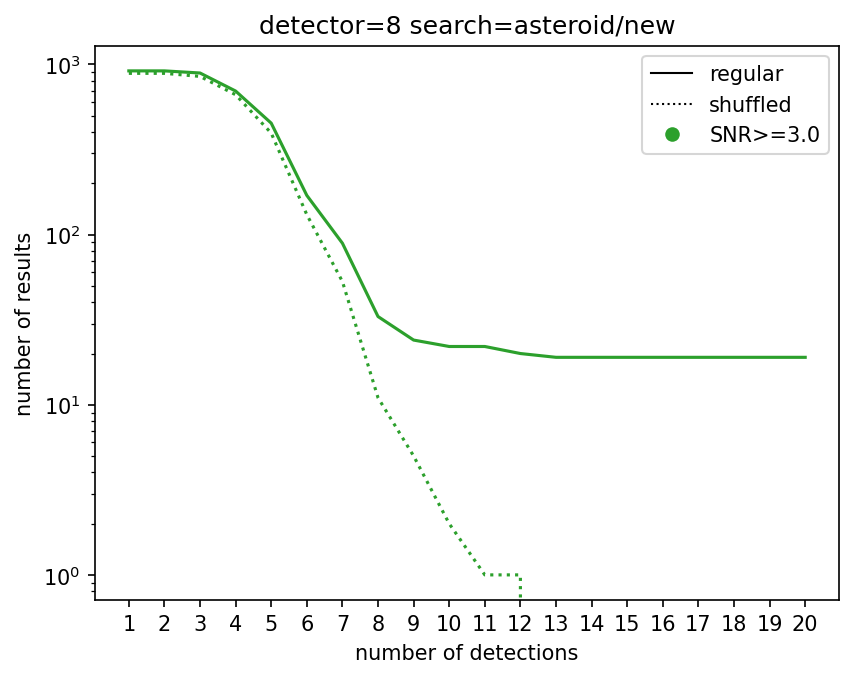

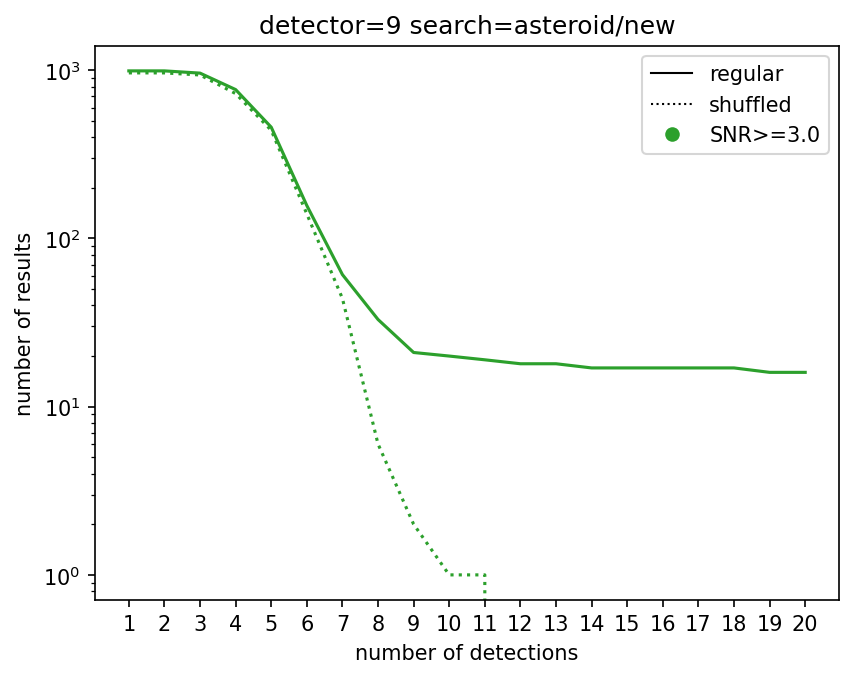

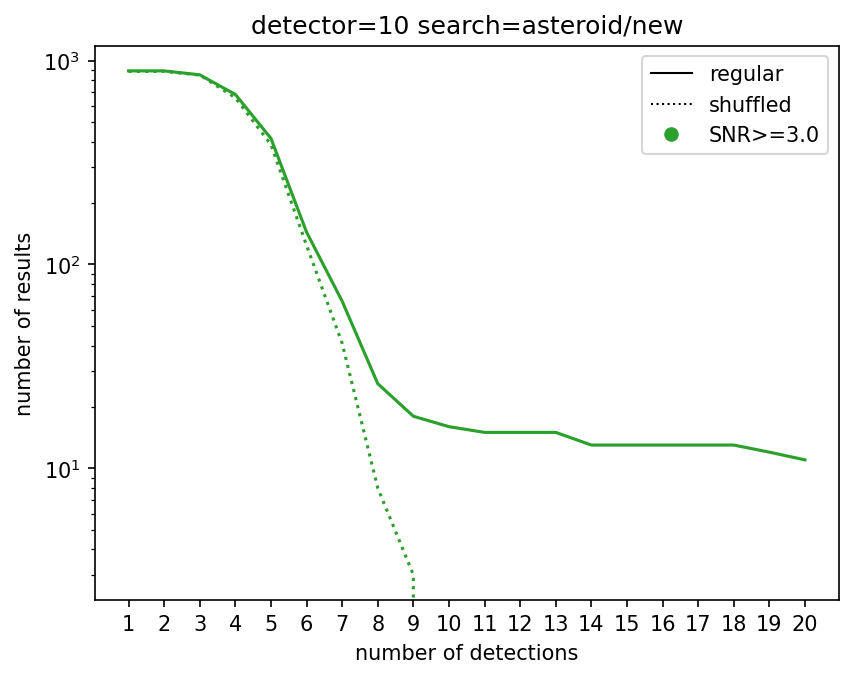

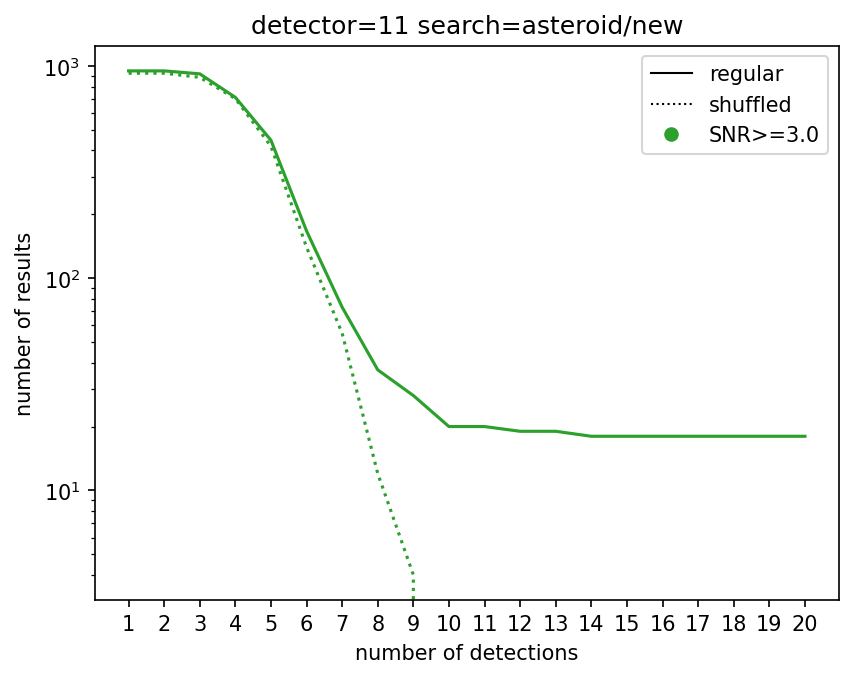

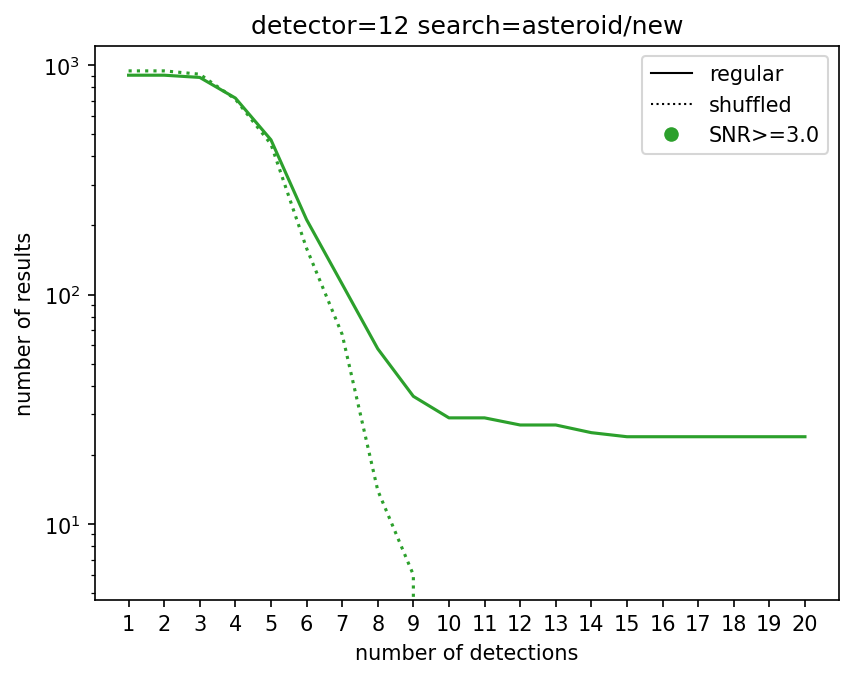

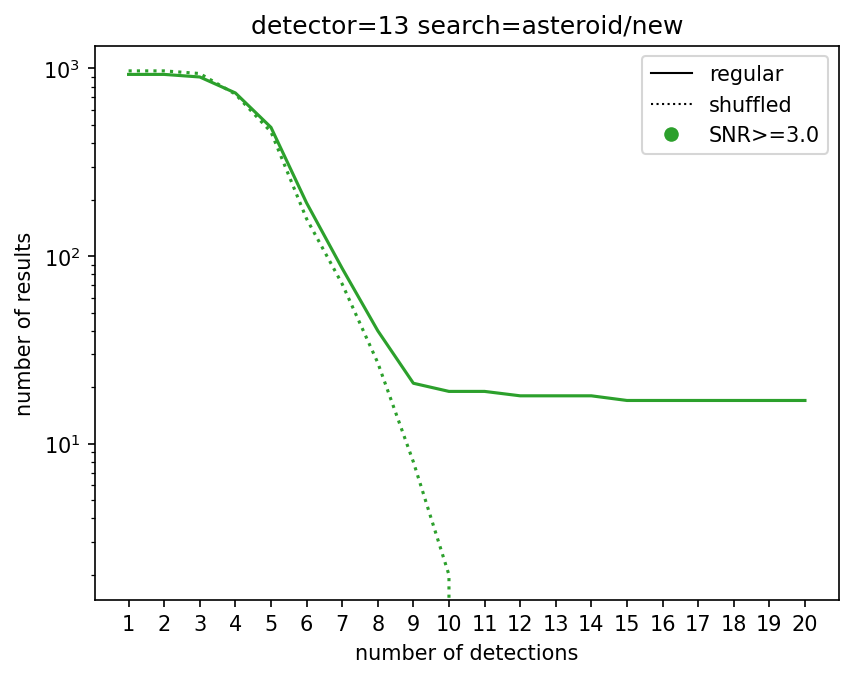

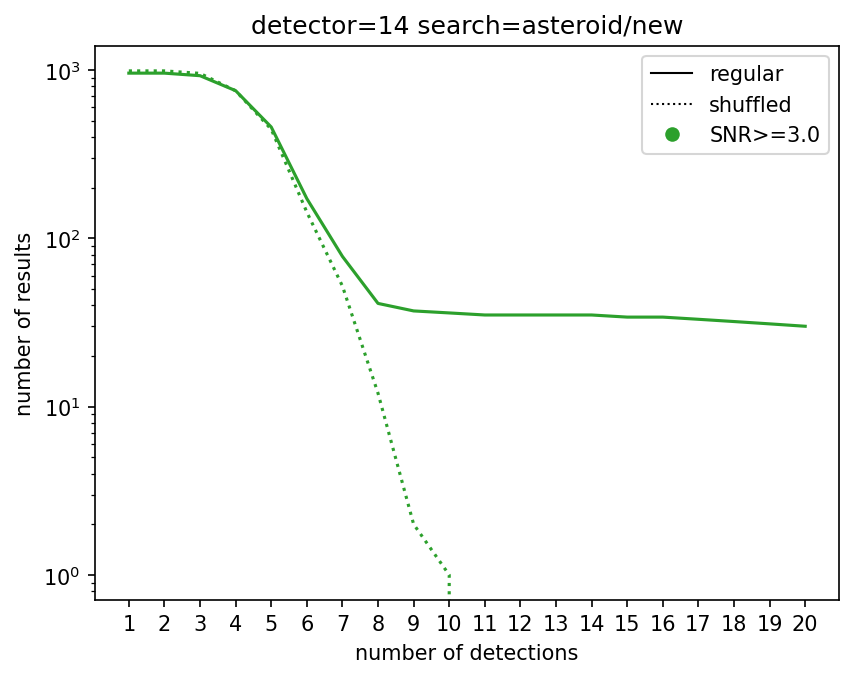

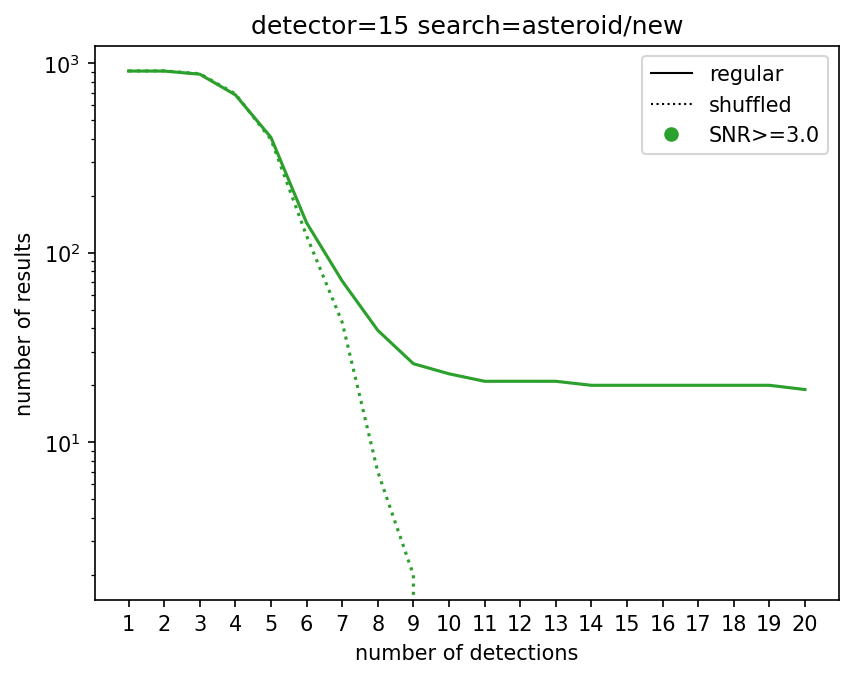

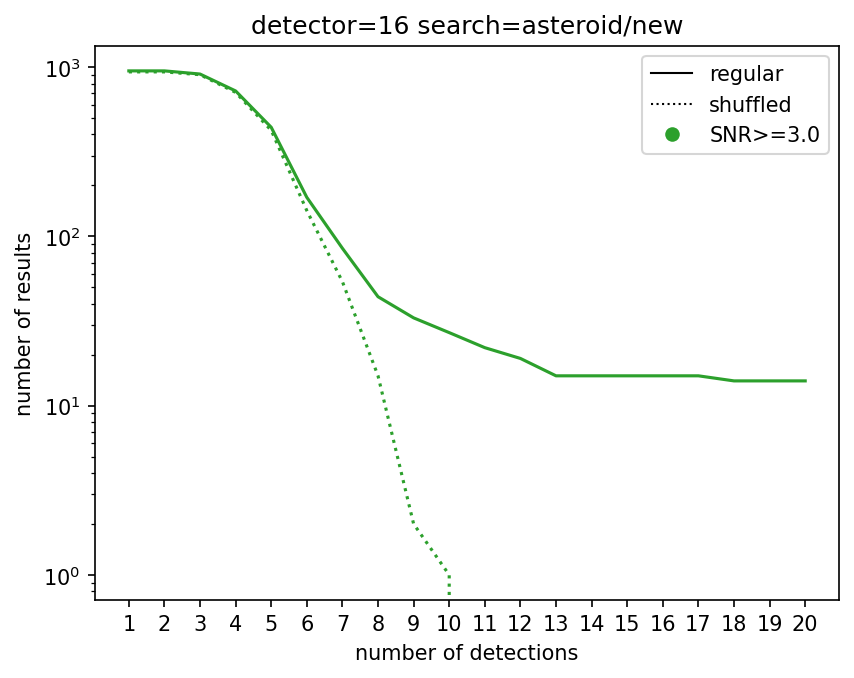

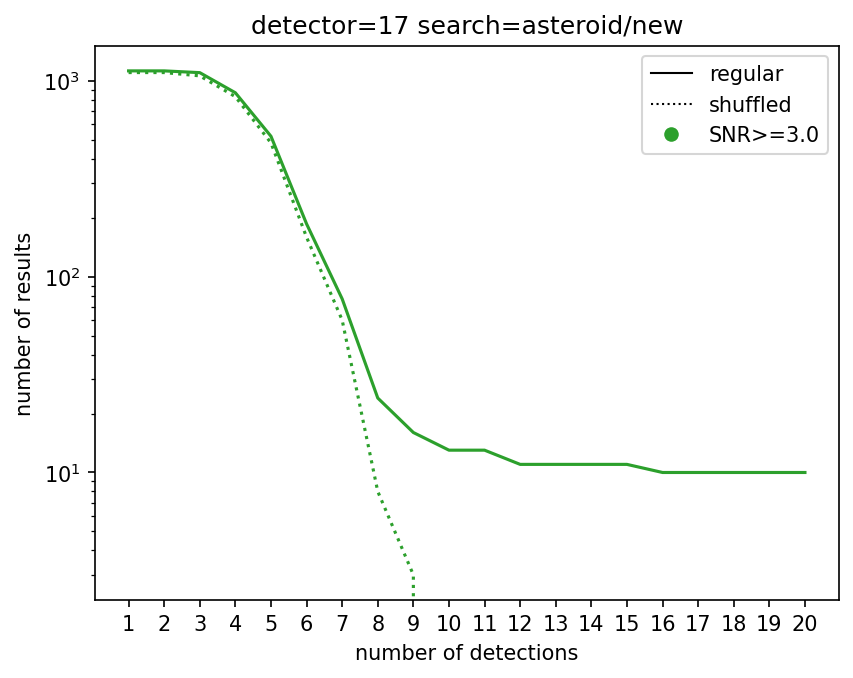

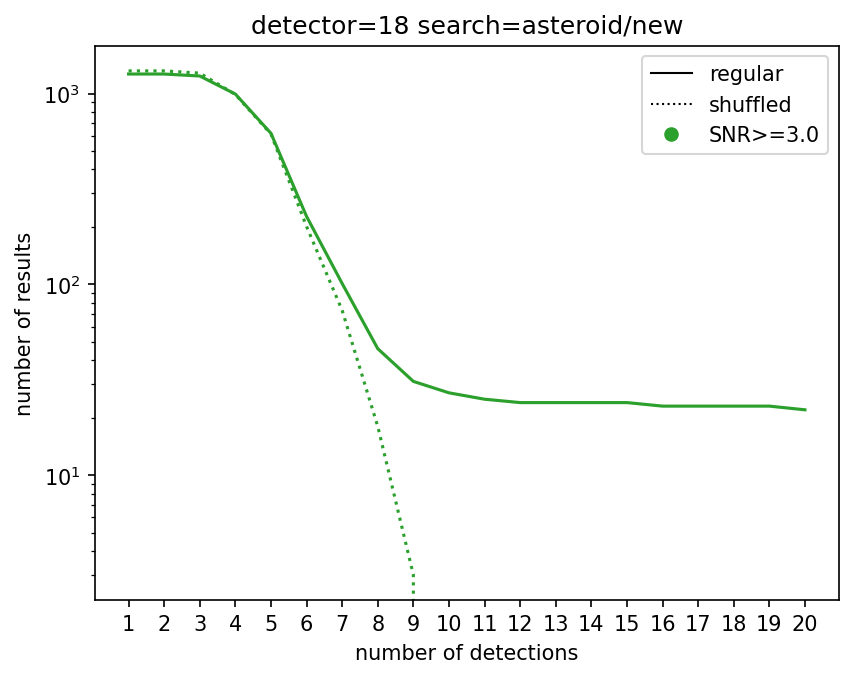

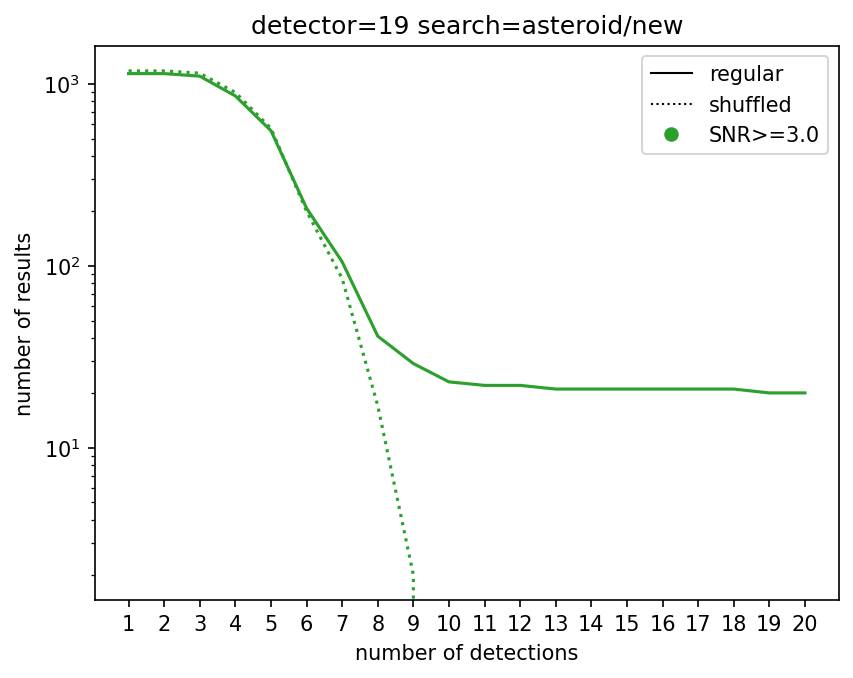

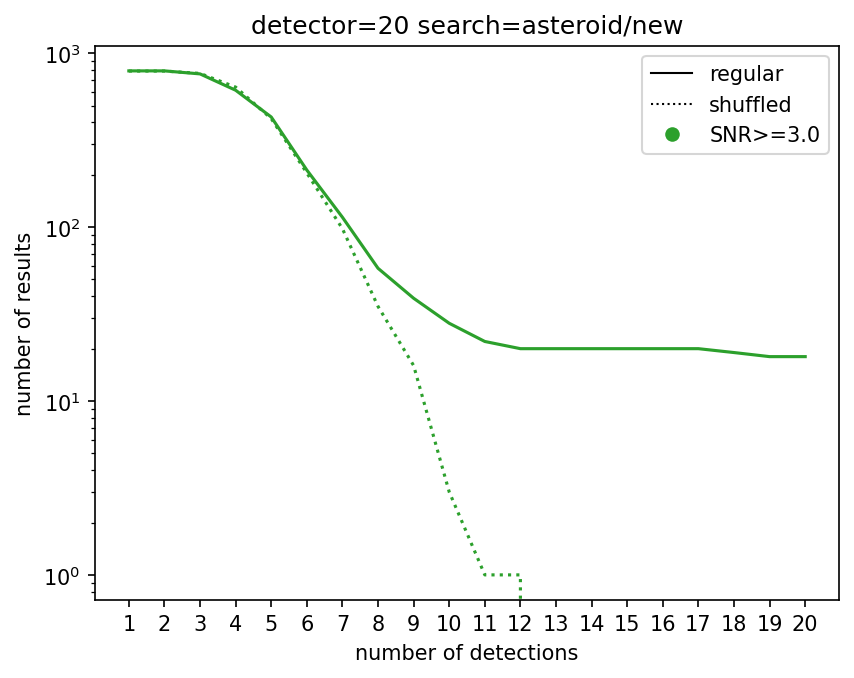

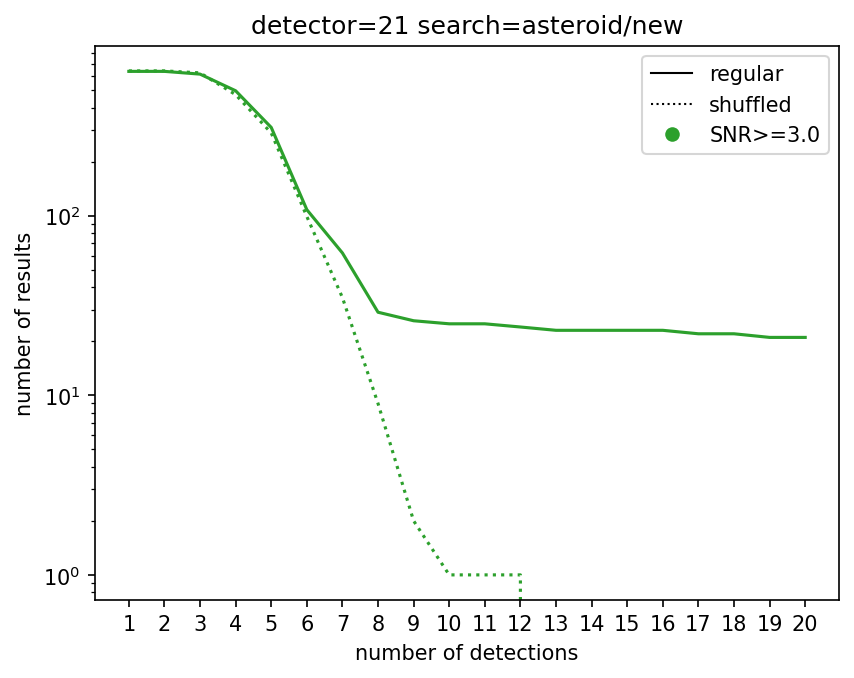

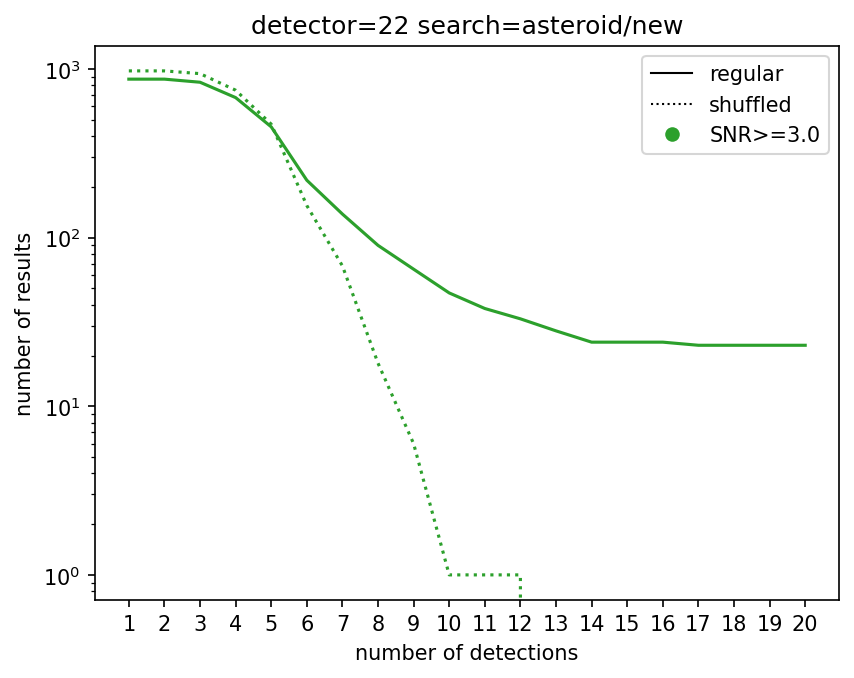

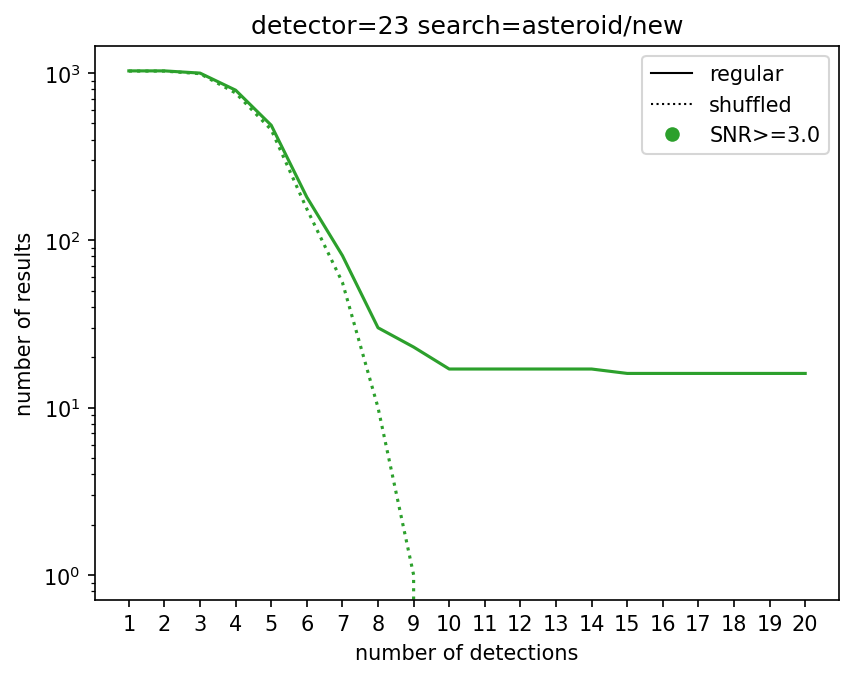

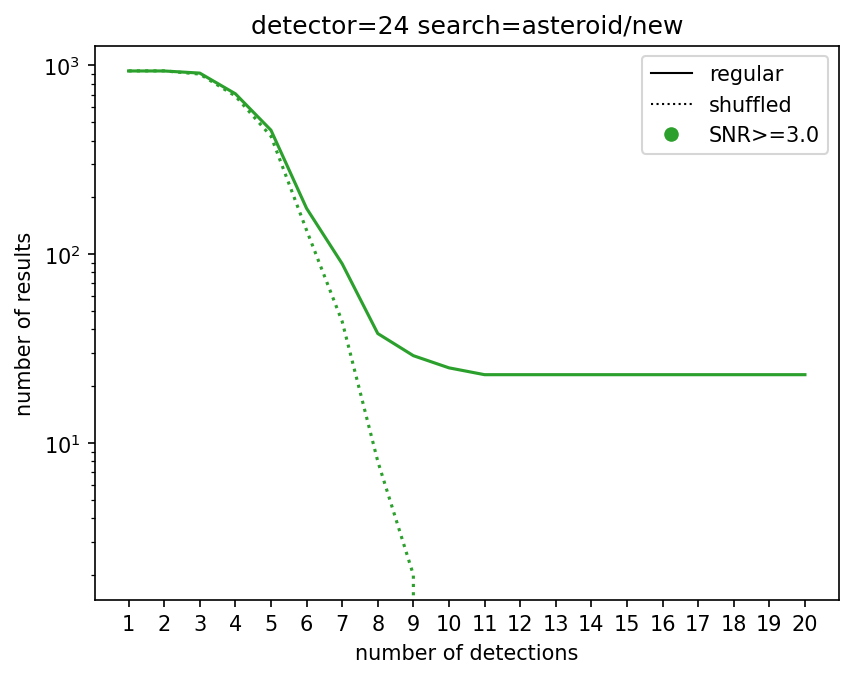

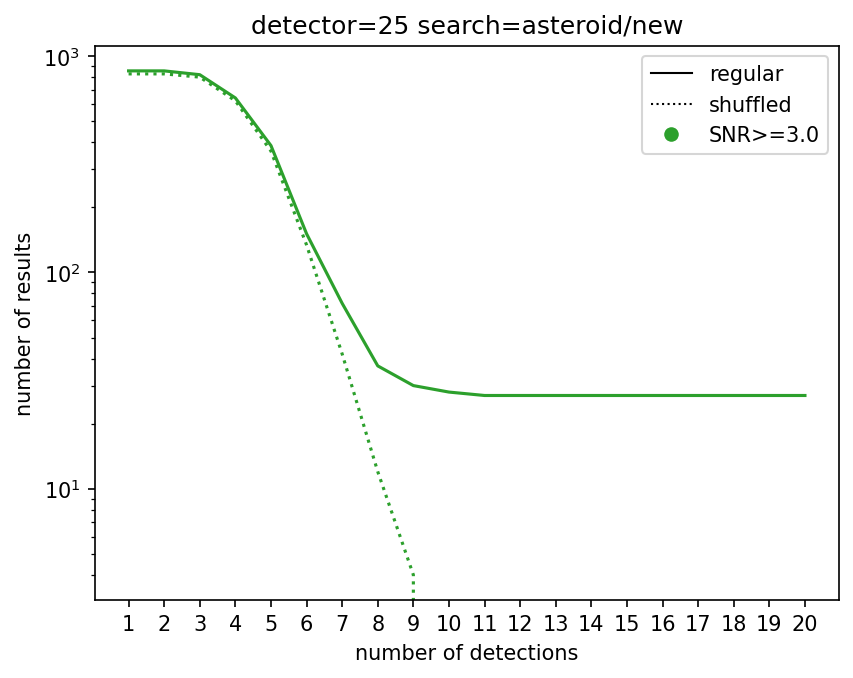

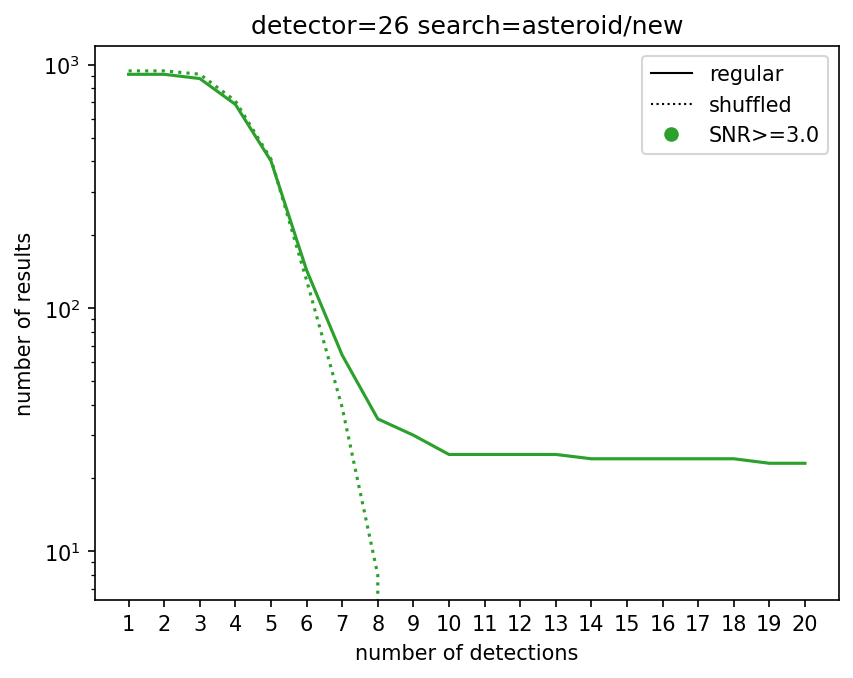

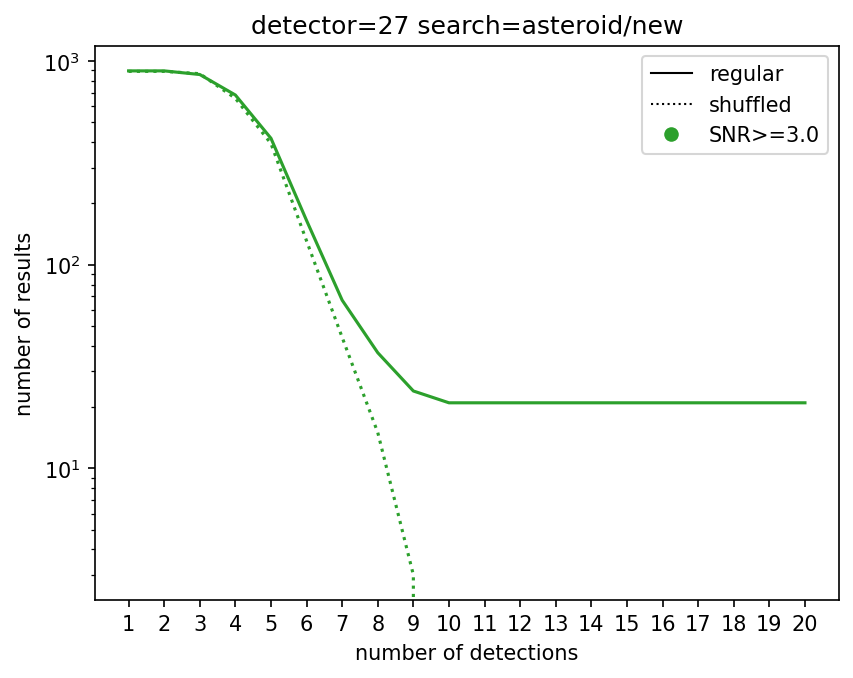

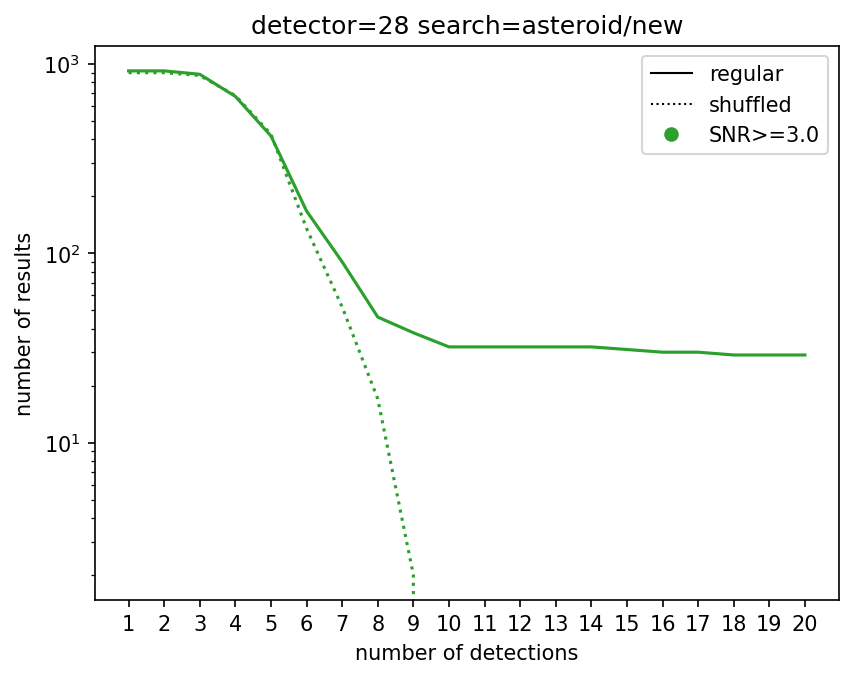

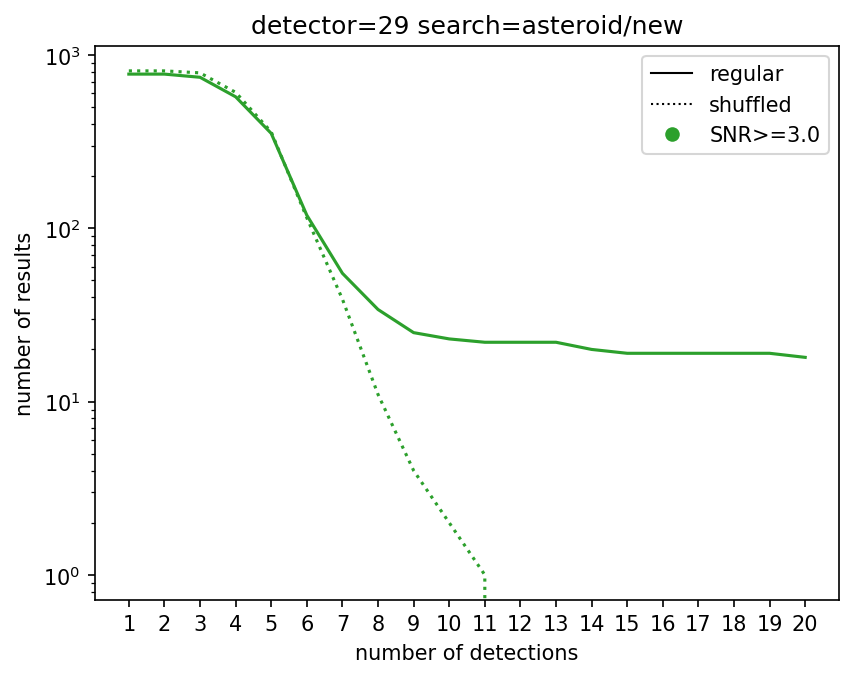

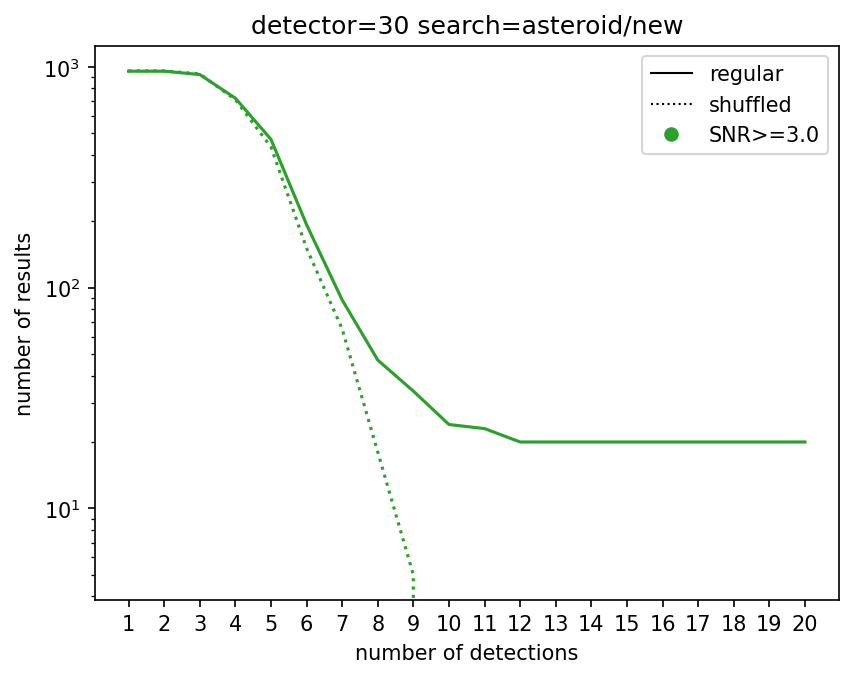

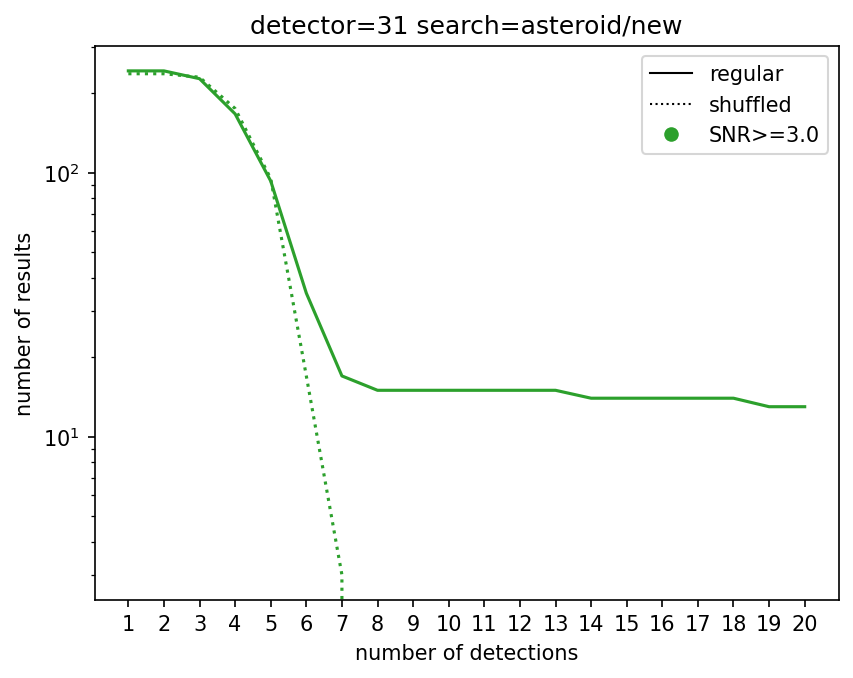

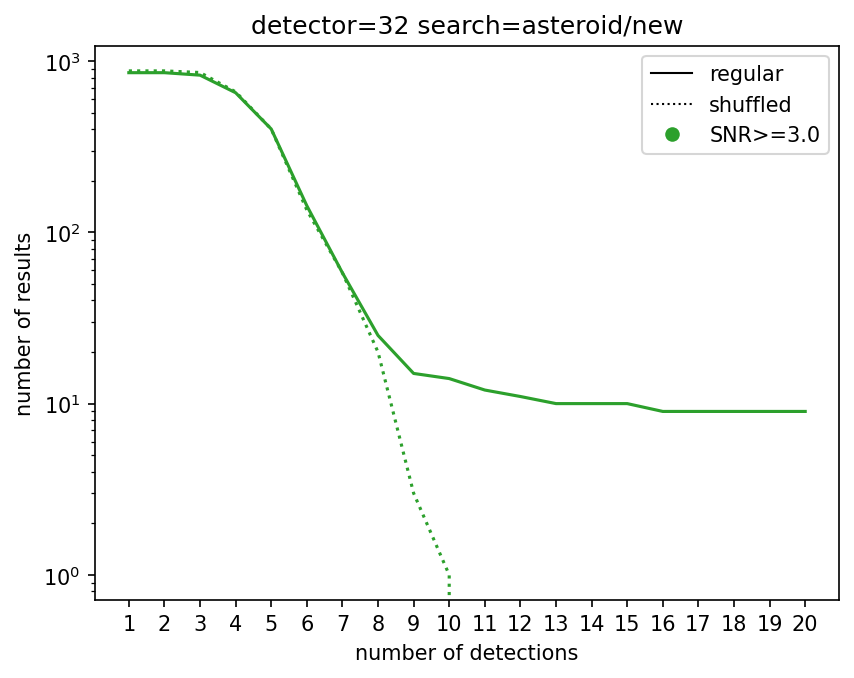

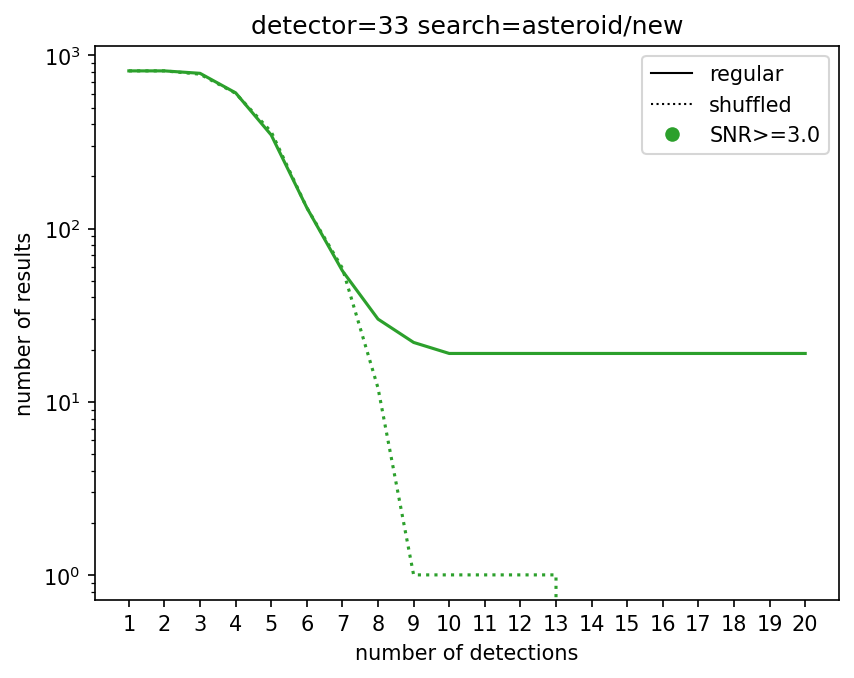

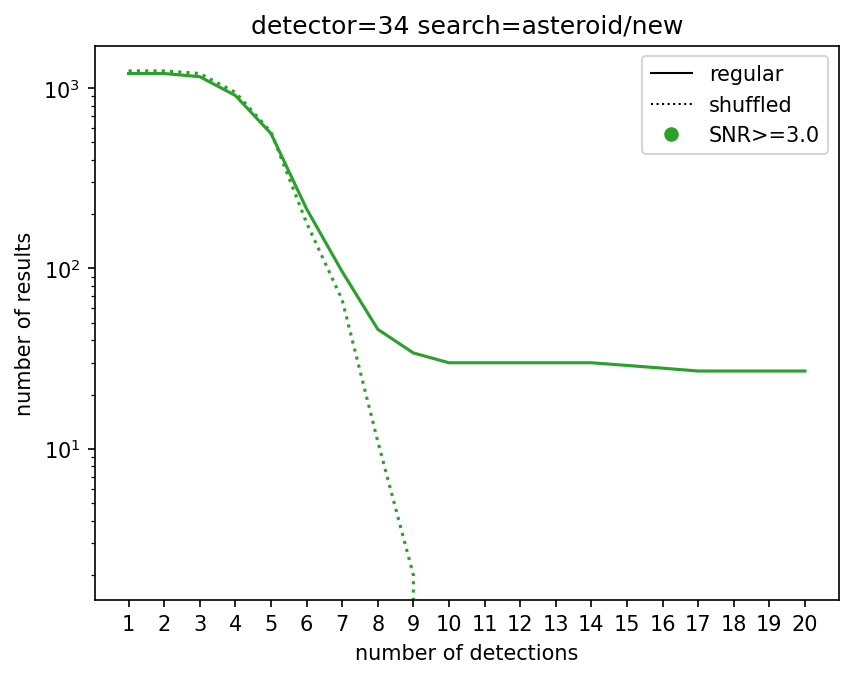

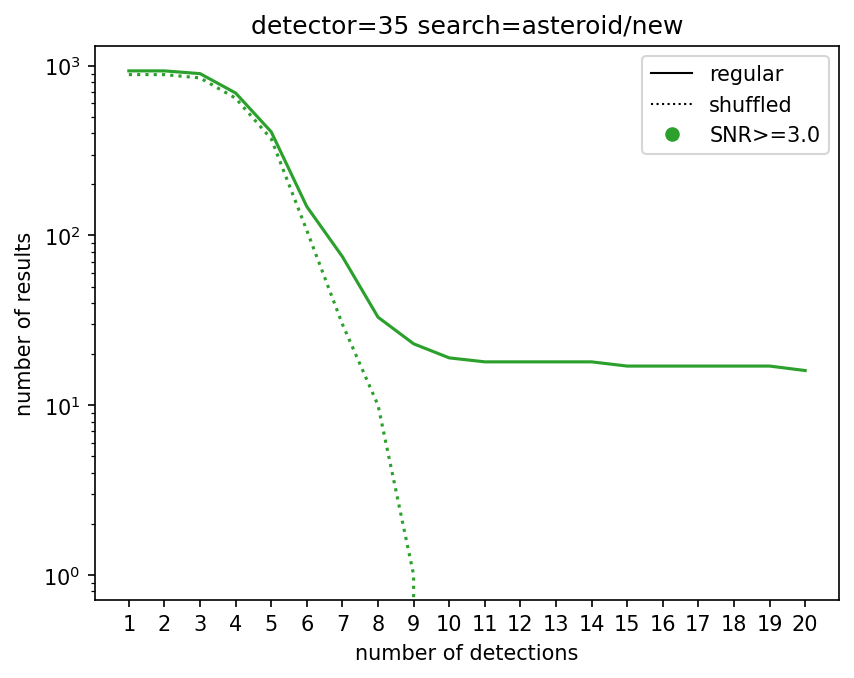

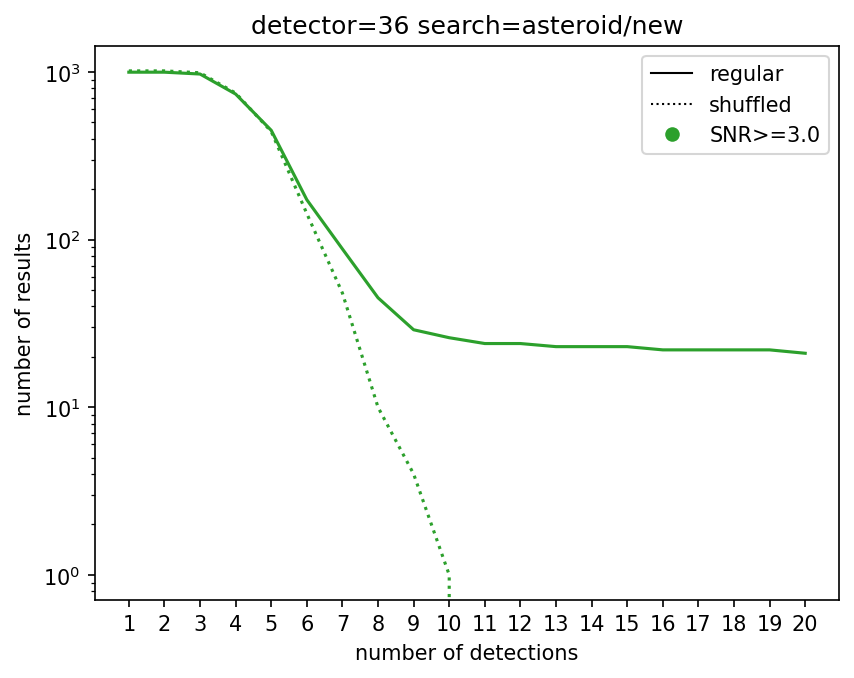

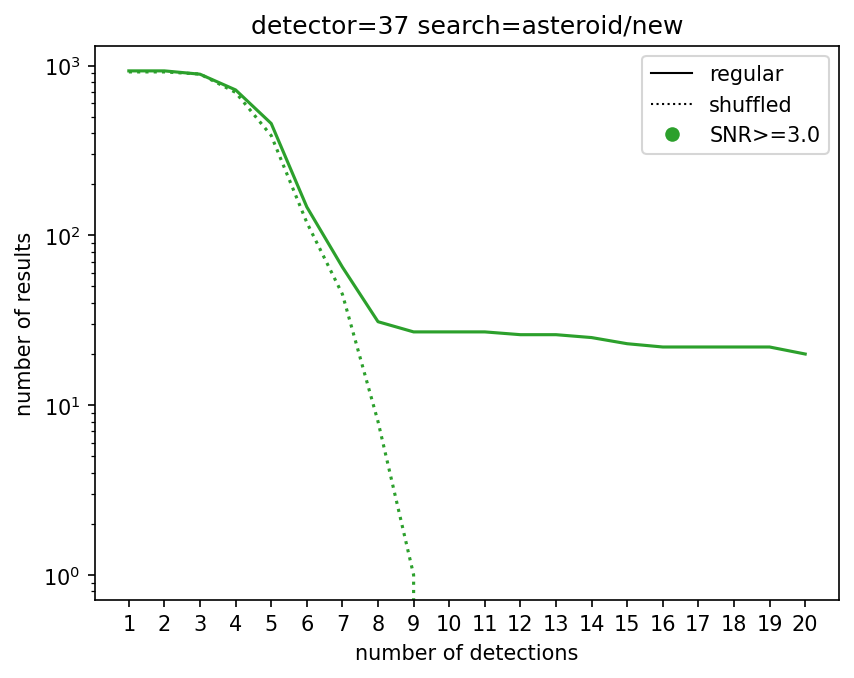

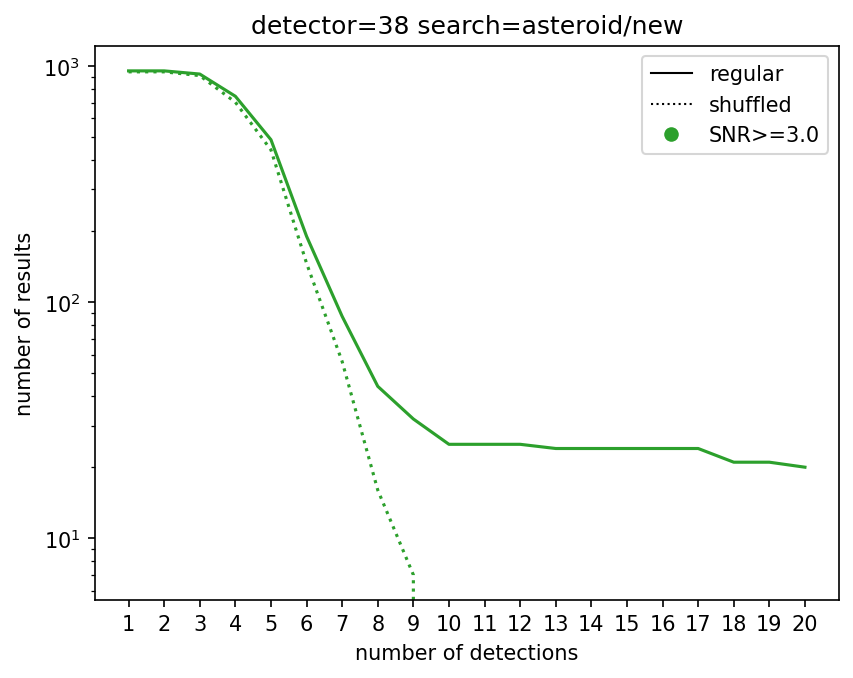

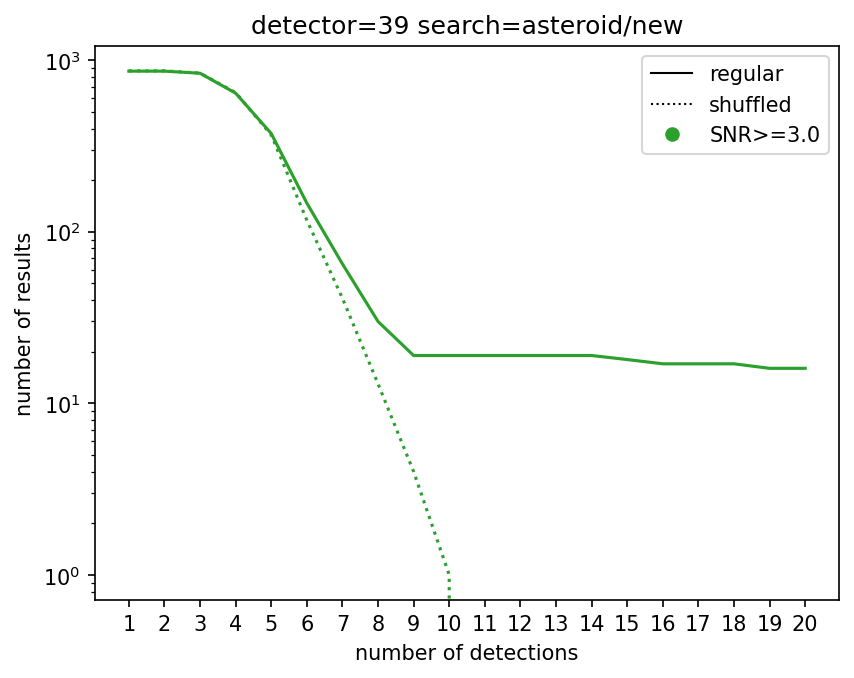

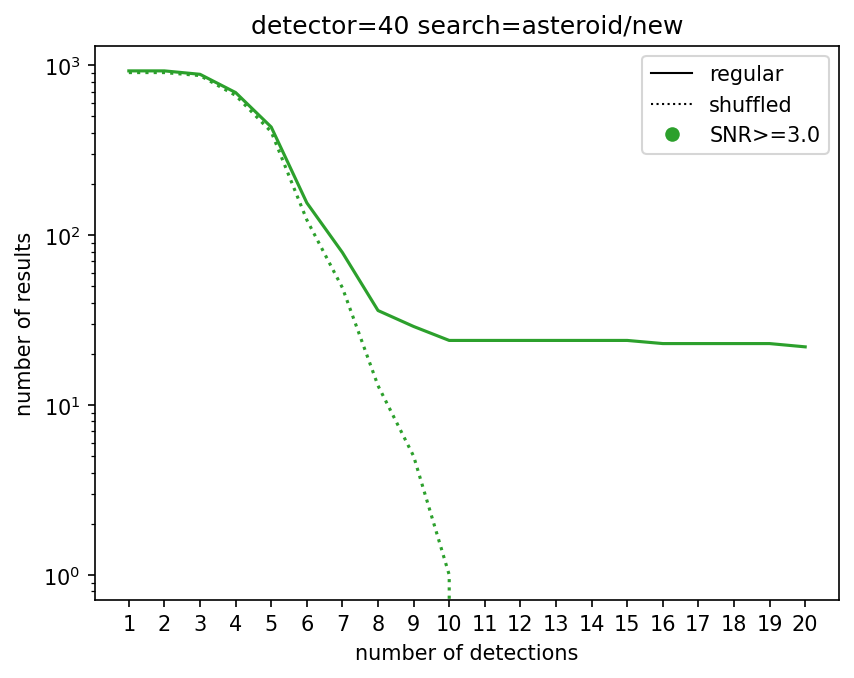

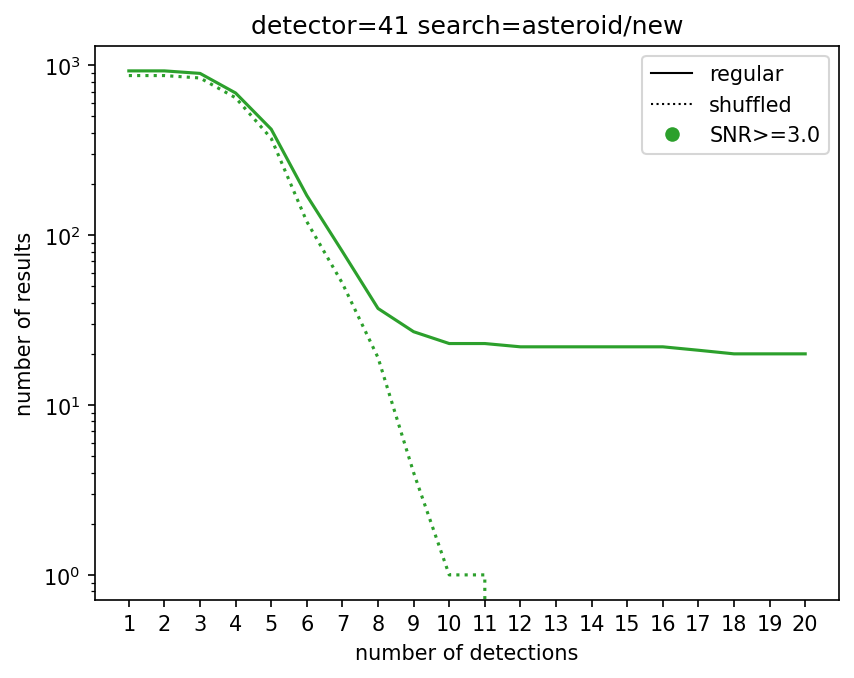

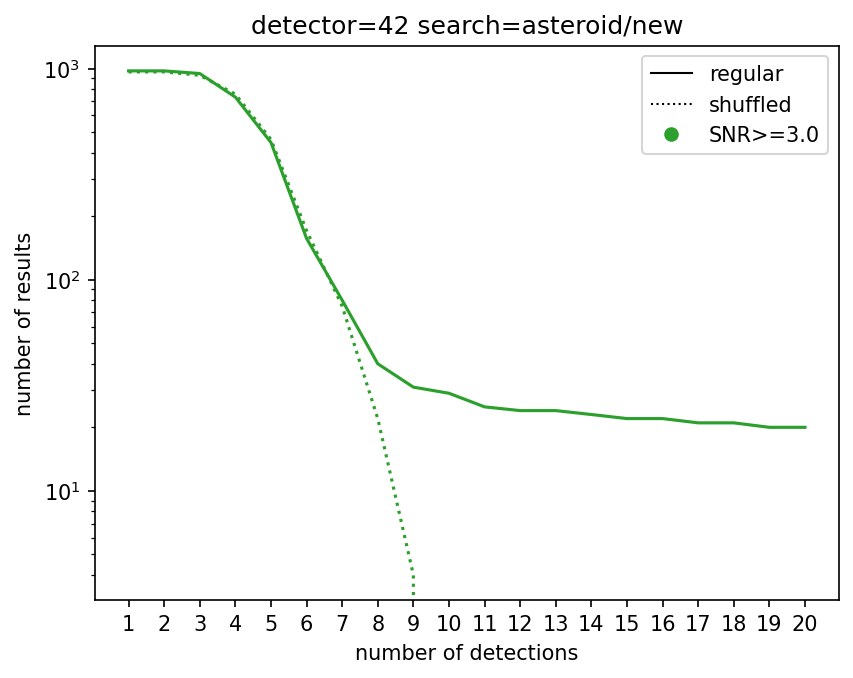

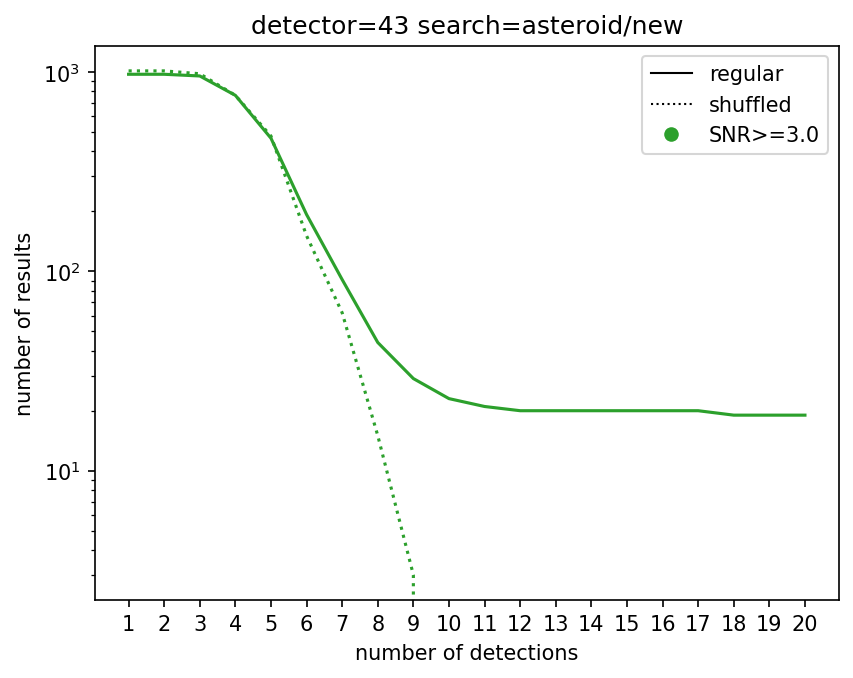

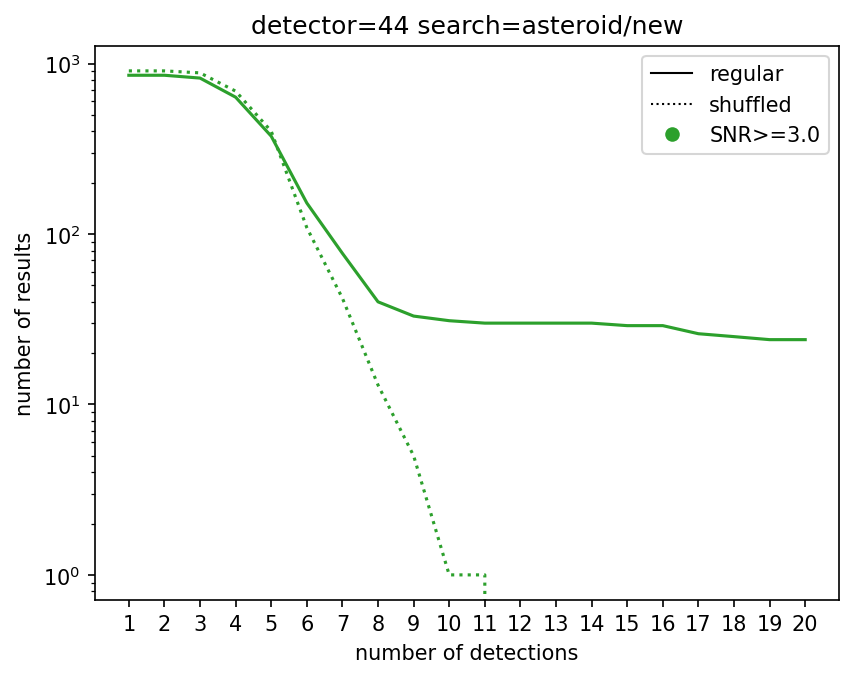

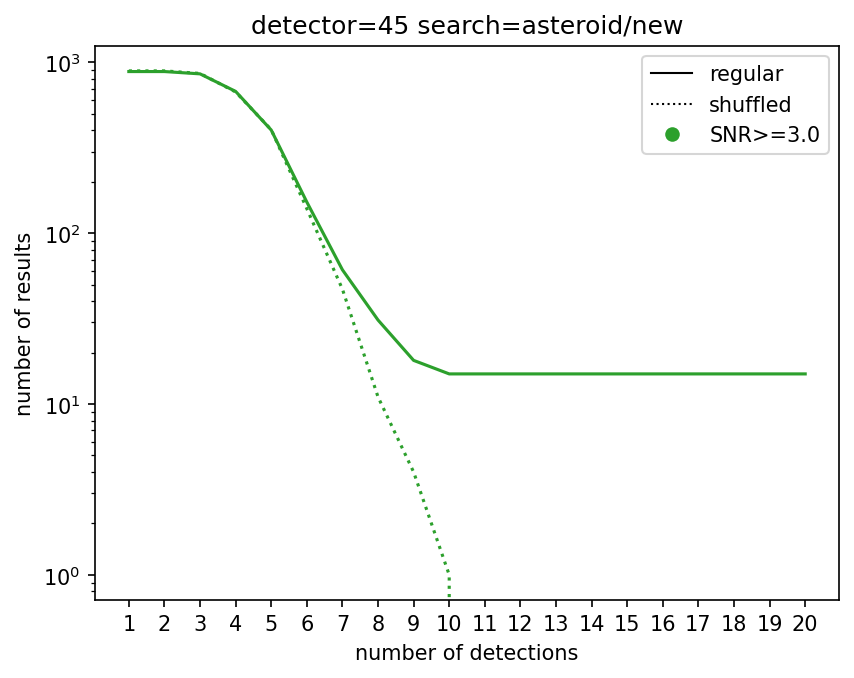

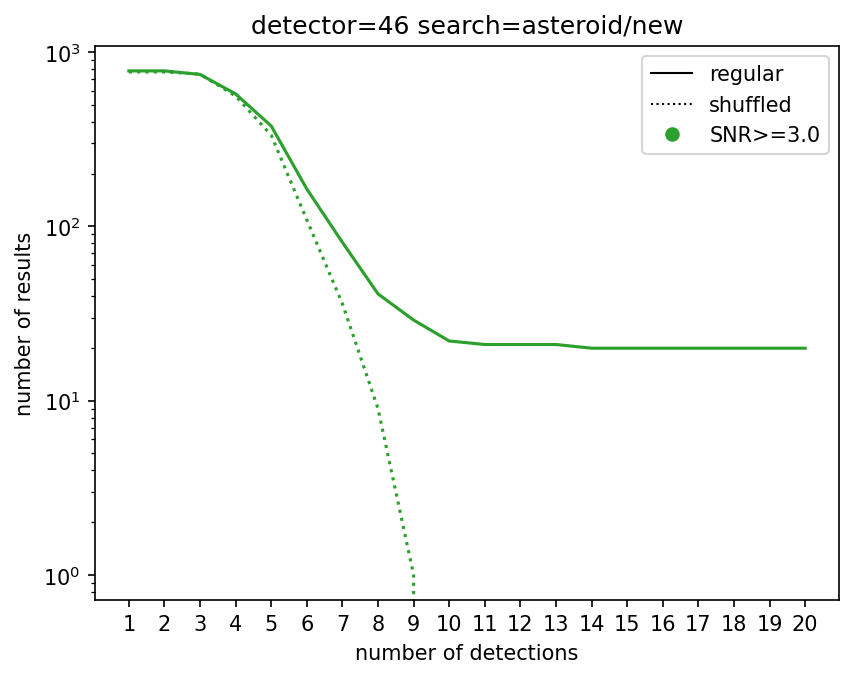

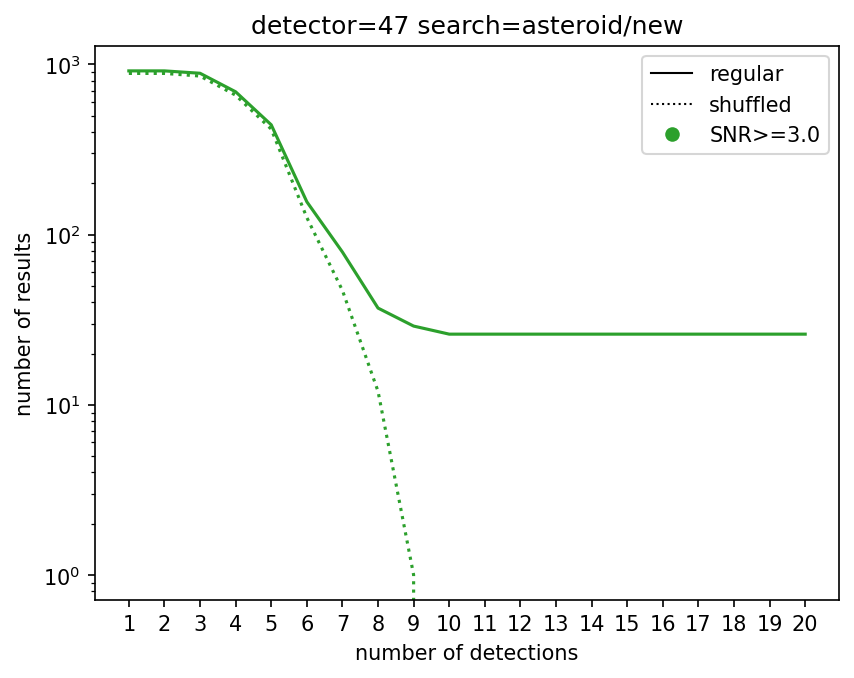

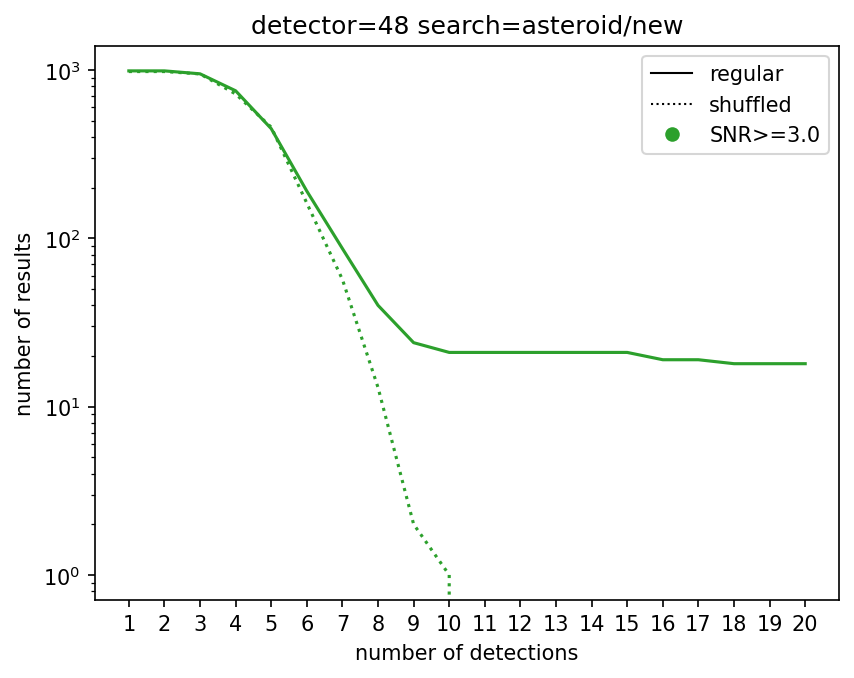

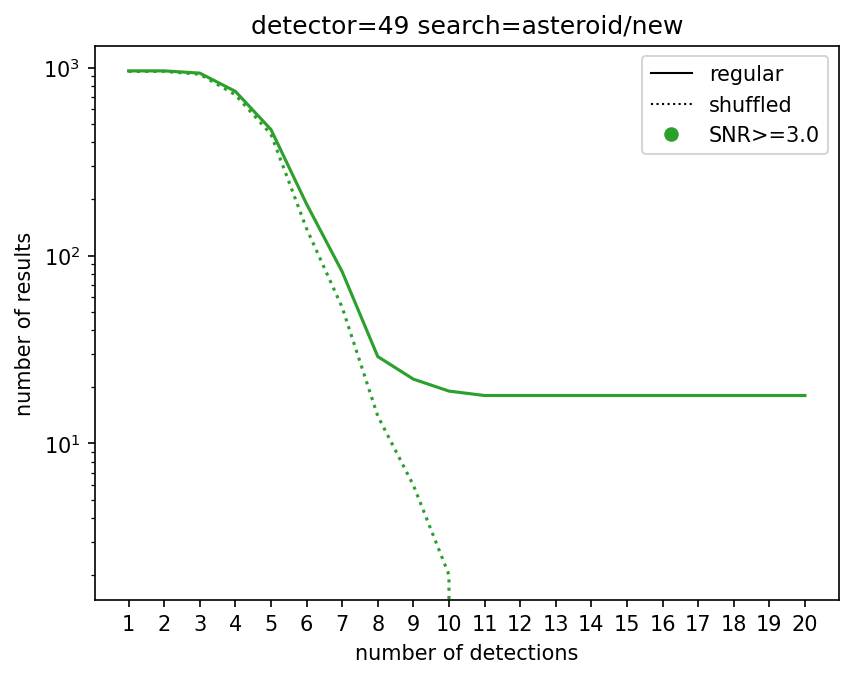

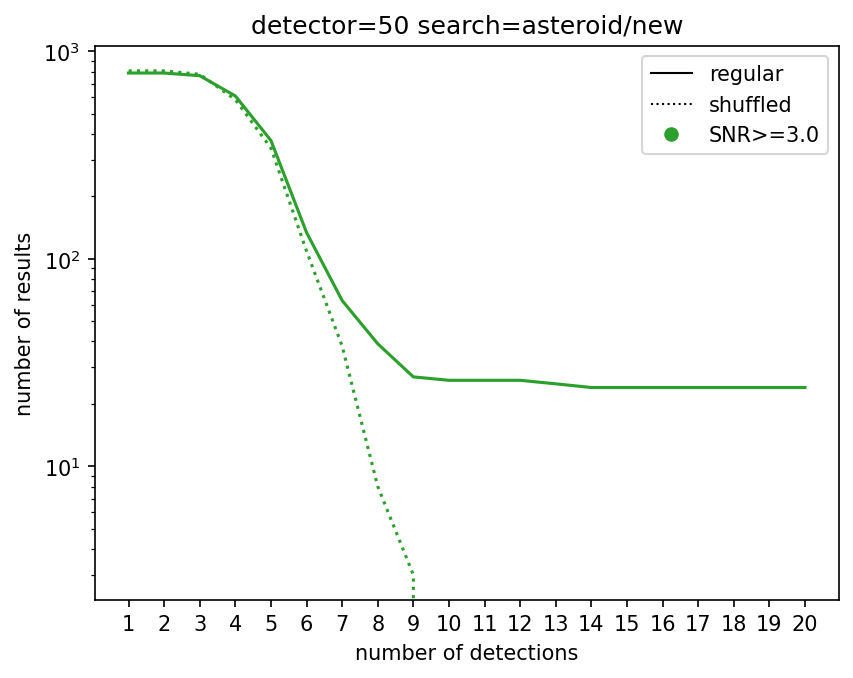

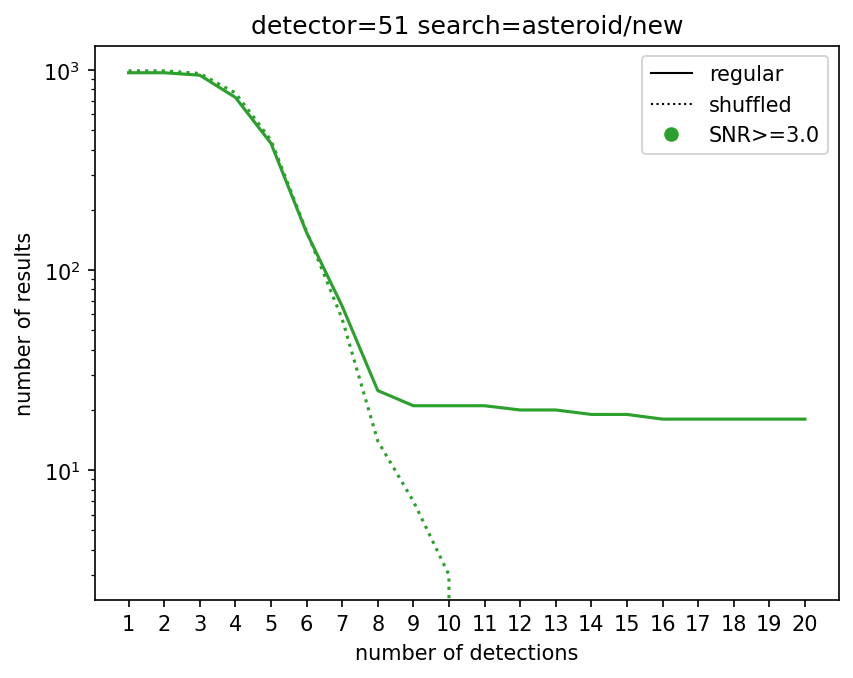

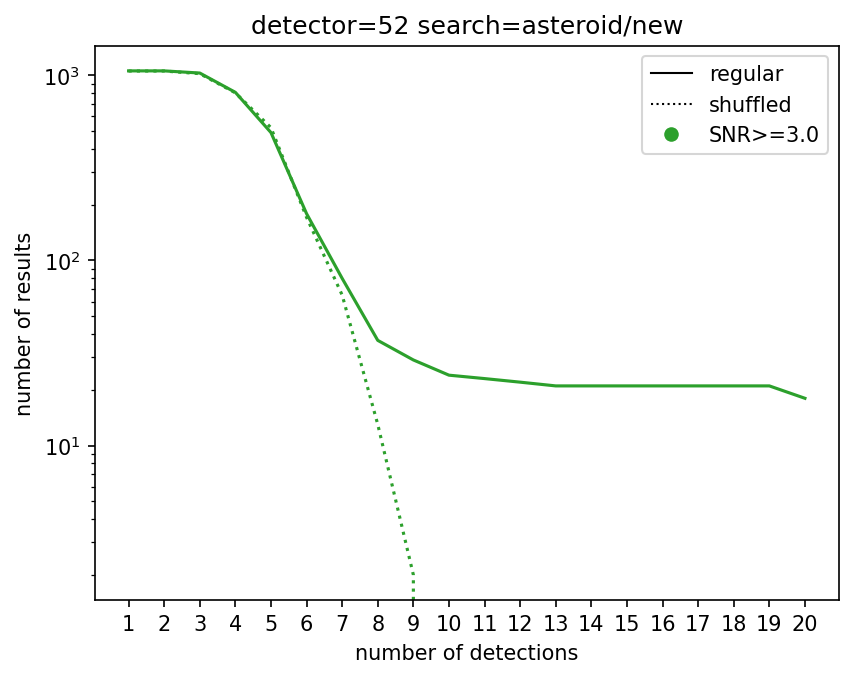

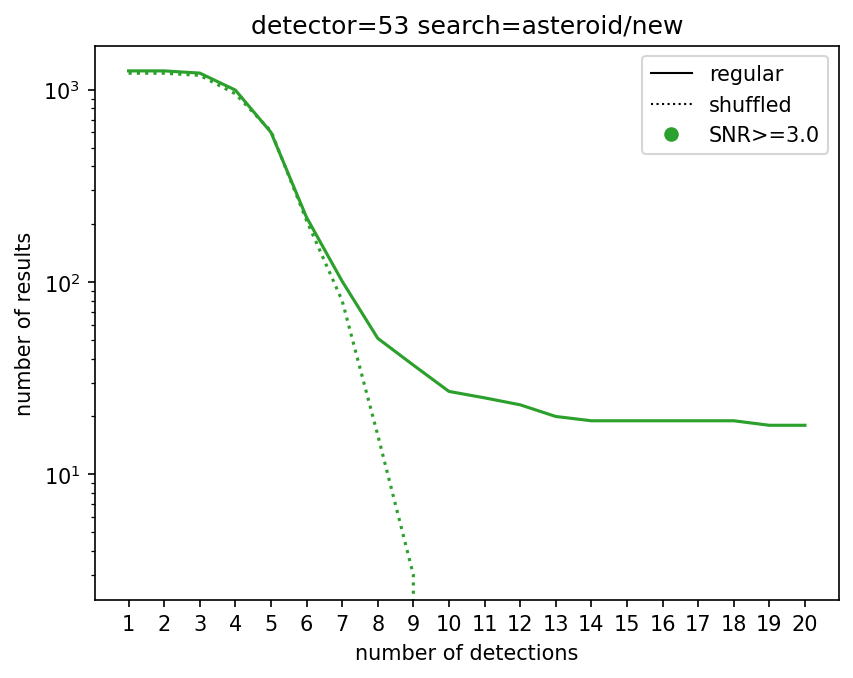

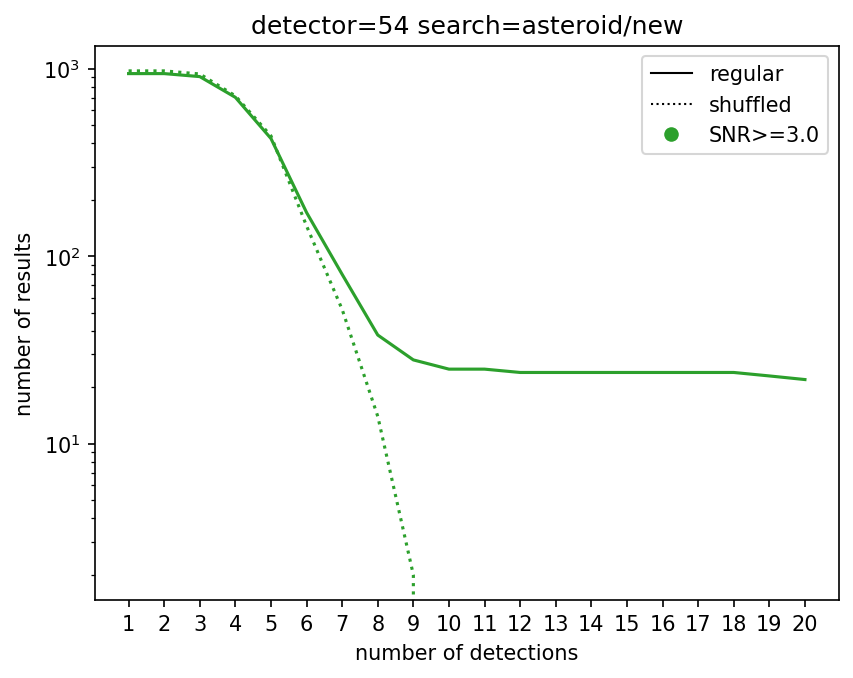

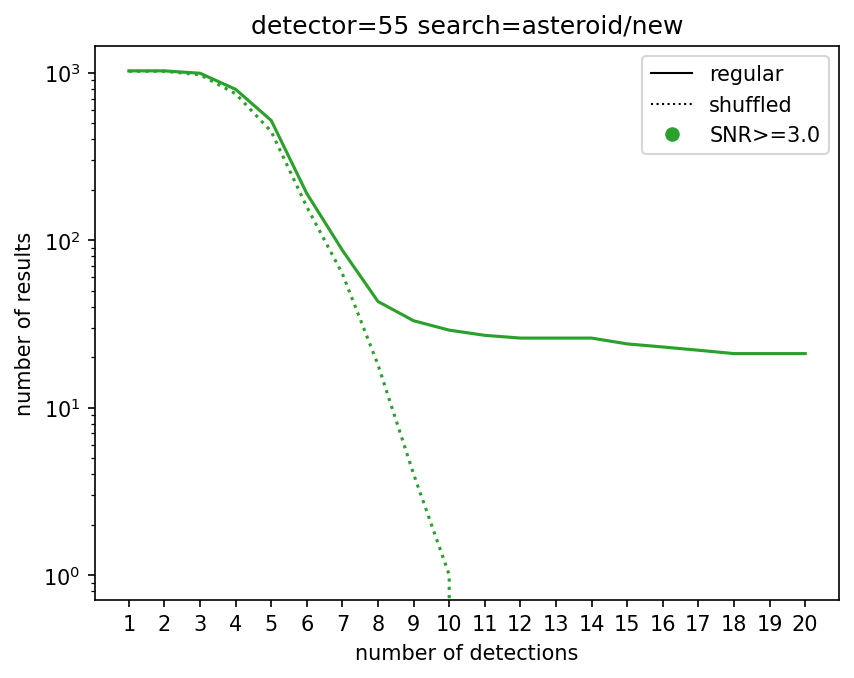

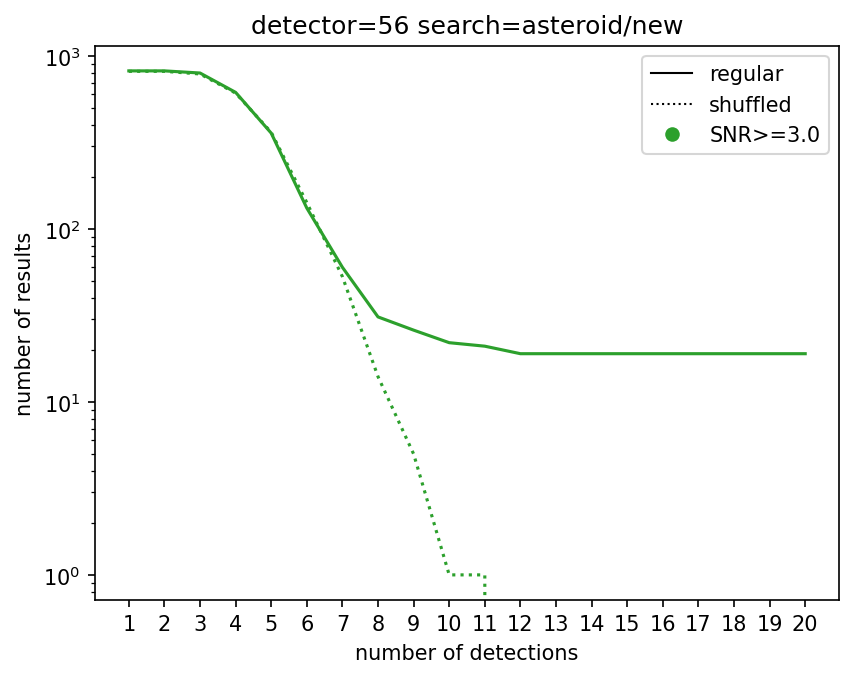

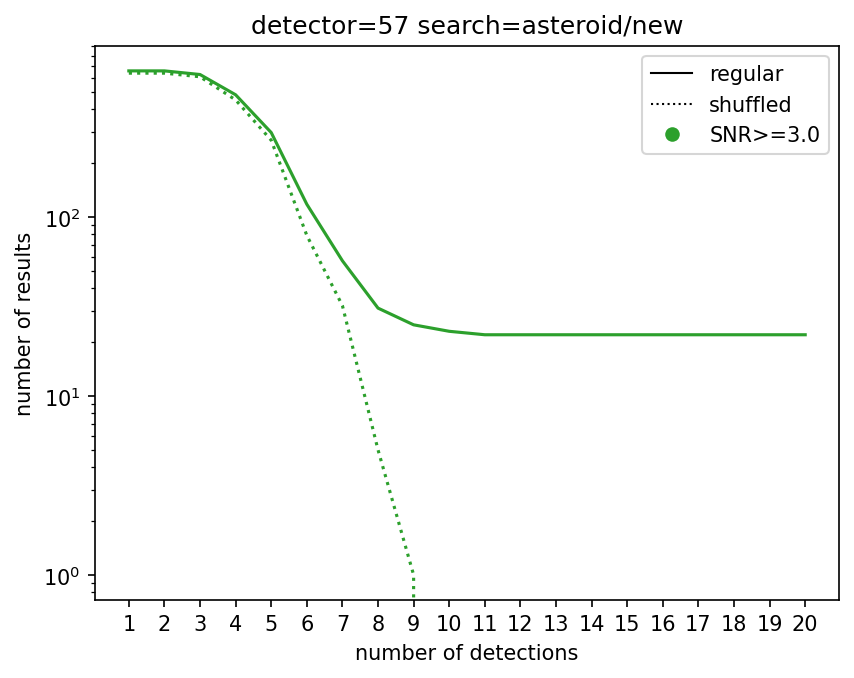

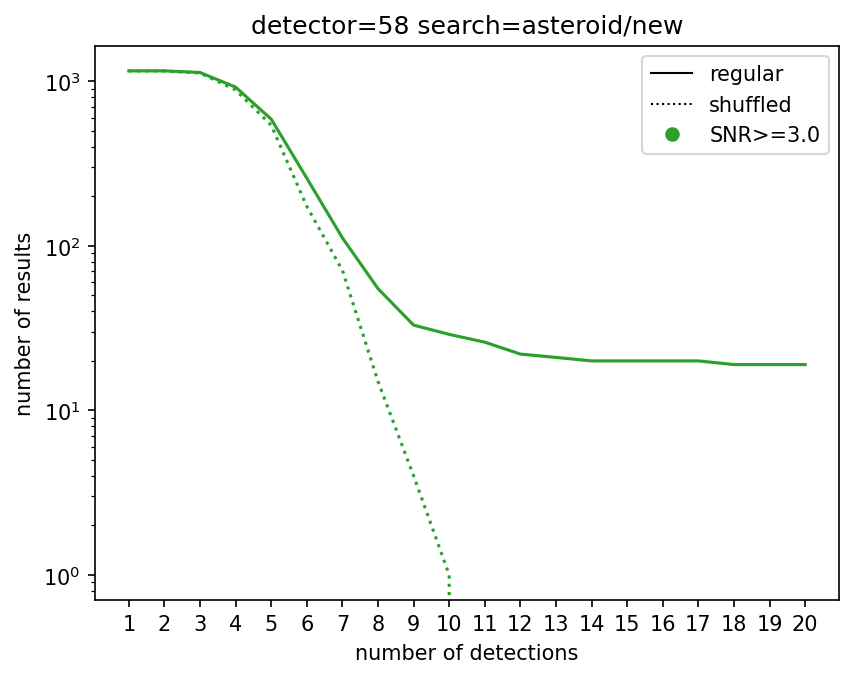

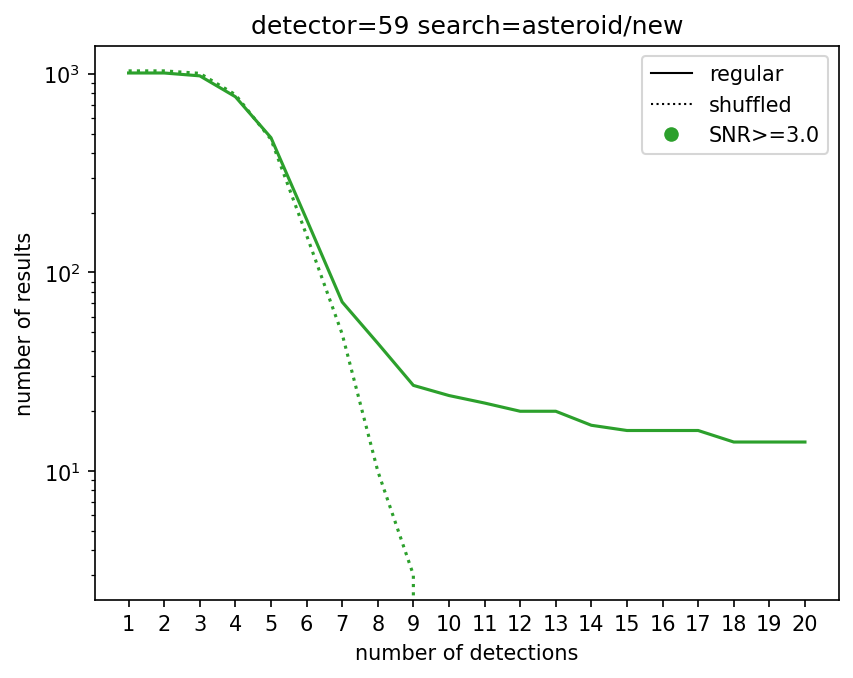

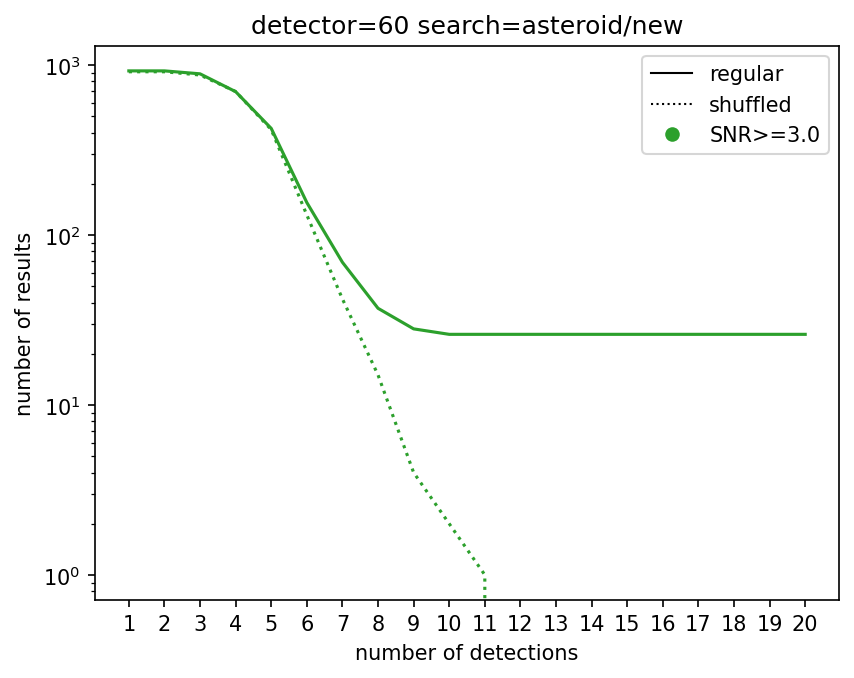

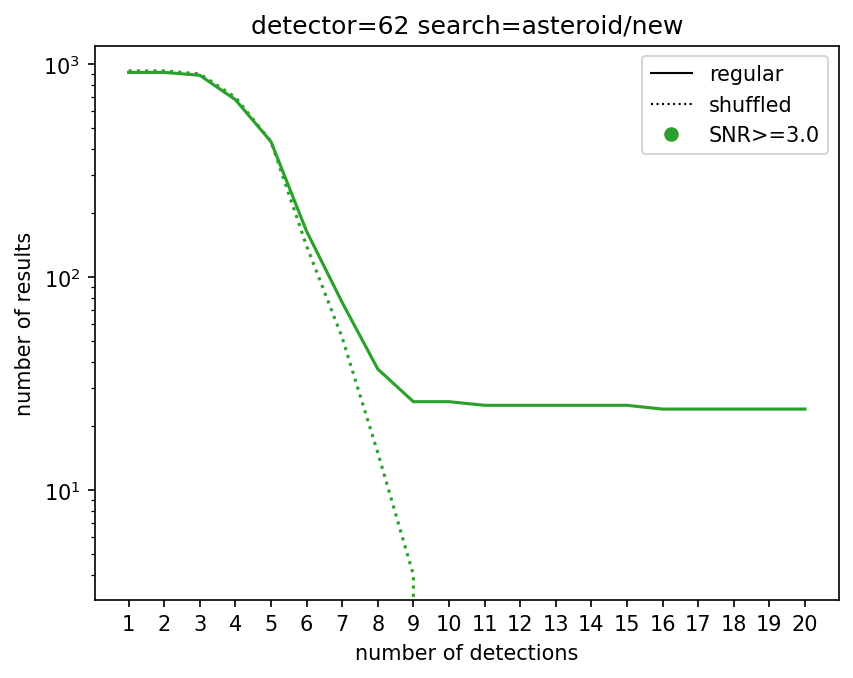

In [14]:
for detector in range(1, 63):
    if detector in [2, 61]:
        continue
    fig = plot_last_step_num_results(0.1, 0.5, 1, 20, "new", detector, "asteroid", snrs=[3.0])
    plt.yscale("log")
    plt.show()

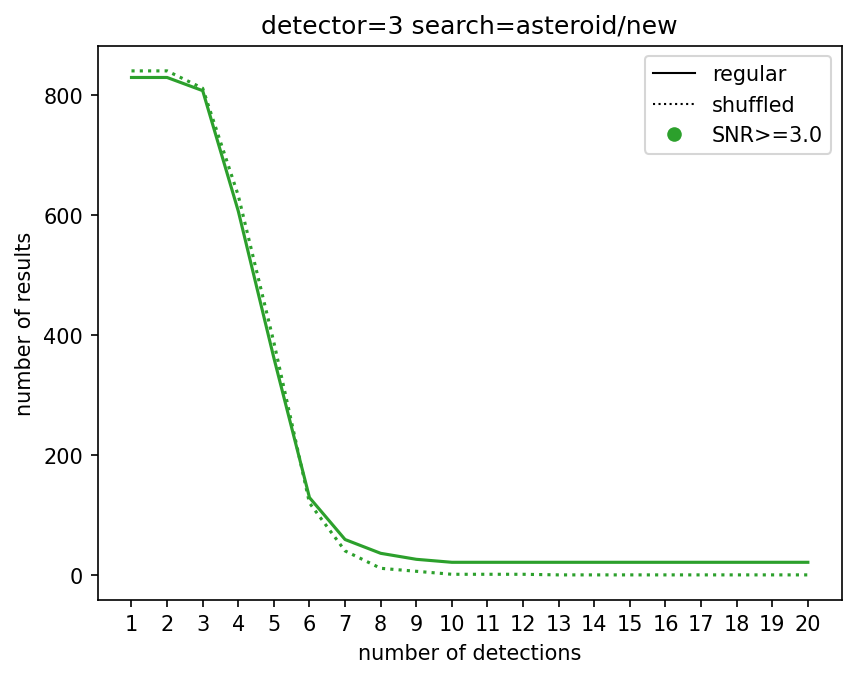

In [11]:
fig = plot_last_step_num_results(0.1, 0.5, 1, 20, "new", 3, "asteroid", snrs=[3.0])
plt.show()

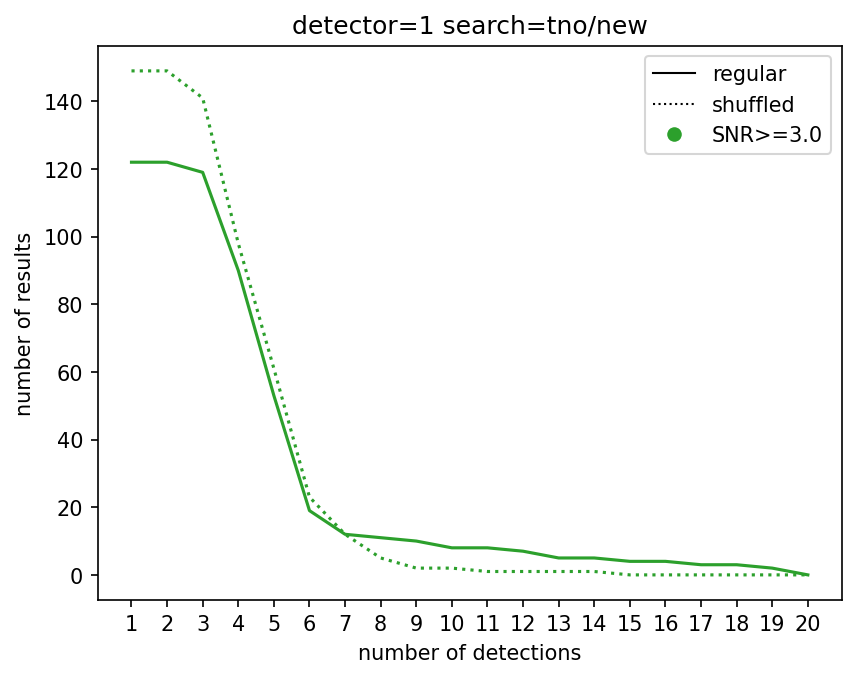

In [63]:
fig = plot_last_step_num_results(0.01, 0.03, 1, 20, "new", 1, "tno", snrs=[3.0])
plt.show()